# Identifying and treating clipped data

Written by George Lu, last updated March 2, 2024

The goal of this notebook is to explain our methodology to treat clipped data. I will go through the steps we take to identify, and then remove data with clipping across seasons. We apply our treatments across seasons to maintain some consistency in analysis. I.e., if half the season has data clipped, and it is solved by only using a smaller segment of the chirp, we will do that across the whole season. 

First, we load some relevant processing libraries and our data.

# Setup

In [4]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:56:10 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:56:10 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:56:10 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [5]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
ds_101

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11703,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-26T17:06:29 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [6]:
# open client
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33521")
client

<Client: 'tcp://127.0.0.1:33521' processes=4 threads=16, memory=125.81 GiB>

In [23]:
# define function to use portion of chirp
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

# function to plot chirp histograms
def plot_hist(ds,ylim=False):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(ncols=atten_count,figsize=(5*atten_count,5))
    
    for i in range(atten_count):
        ds.chirp.isel(attenuator_setting_pair=i).mean(dim='chirp_num').plot.hist(ax=axs[i],bins=100)
        axs[i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[i].set_ylabel('count')
        axs[i].set_xlabel('chirp voltage [V]')
        if ylim:
            old_lim = axs[i].get_ylim()
            axs[i].set_ylim([old_lim[0],old_lim[1]*0.2])

def plot_amplitude_trends(ds):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(nrows=3,ncols=atten_count,figsize=(5*atten_count,15))
    for i in range(atten_count):
        # Over chirp 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='mean')
        axs[0][i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[0][i].set_ylabel('')
        axs[0][i].set_xlabel('chirp time')
        axs[0][i].legend()

        # Over chirp number 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='mean')
        axs[1][i].set_ylabel('')
        axs[1][i].set_xlabel('chirp number')
        axs[1][i].set_title('')

        # over burst time
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='mean')
        axs[2][i].set_ylabel('')
        axs[2][i].set_xlabel('date')
        axs[2][i].set_title('')
    
    axs[0][0].set_ylabel('chirp magnitude over chirp time [V]')
    axs[1][0].set_ylabel('chirp magnitude over chirp number [V]')
    axs[2][0].set_ylabel('burst magnitude over time [V]')

def plot_bad_chirp_count(ds):
    # input ds should be the form of ds.isel(attenuator_setting_pair=i).chirp.where(condition)
    fig, axs = plt.subplots(ncols=3,figsize=(15,5),layout='tight')
    ds.count(dim=['chirp_num','time']).plot(ax=axs[0],linestyle='None',marker='.')
    axs[0].set_ylabel('count')
    axs[0].set_title('Total instances of clipping in chirp section')
    
    (ds.max(dim='chirp_time').count(dim='time')/(ds.max(dim='chirp_time').count())).plot(ax=axs[1],linestyle='None',marker='.')
    axs[1].set_ylabel('fraction of total clipped chirps')
    axs[1].set_title('Clipped chirp distribution by chirp number')
    
    ds.max(dim='chirp_time').count(dim='chirp_num').plot(ax=axs[2],linestyle='None',marker='.')
    axs[2].set_ylabel('count')
    axs[2].set_title('Number of chirps with clipping in each burst')

def plot_profile(example_chirp):
    fig, axs = plt.subplots(ncols=2,figsize=(10,5))
    for i in [0,1]:
        example_chirp.isel(attenuator_setting_pair = i).chirp.mean(dim='chirp_num').plot(ax=axs[0],label = f'G = {int(example_chirp.AFGain[i].values)} dB, A = {int(example_chirp.attenuator[i].values)} dB')
        xa.dB(example_chirp.isel(attenuator_setting_pair = i).profile_stacked).plot(ax=axs[1])
    axs[0].legend()
    axs[0].set_title('Chirp')
    axs[0].set_ylabel('voltage [V]')
    axs[0].set_xlabel('chirp time [ns]')
    
    axs[1].set_title('Profile')
    axs[1].set_ylabel('reflector amplitude [dB]')
    axs[0].set_xlabel('range [m]')

We do our analysis station by station, season by season. We plot histograms of each stacked chirp (taking the mean of each 20-chirp burst) across the season for our different attenuation and gain settings. We prioritize using signals that have a wide spread, as they are the least attenuated. However, if sidelobes appear on the histogram, this means that there is clipping. We visually inspect for instances of this, and then we apply fixes to remove them. Additional details will be given in the A11 Summer 2022 data analysis.

# A11

## Summer 2022


First, we plot our histograms with all the full chirps below.

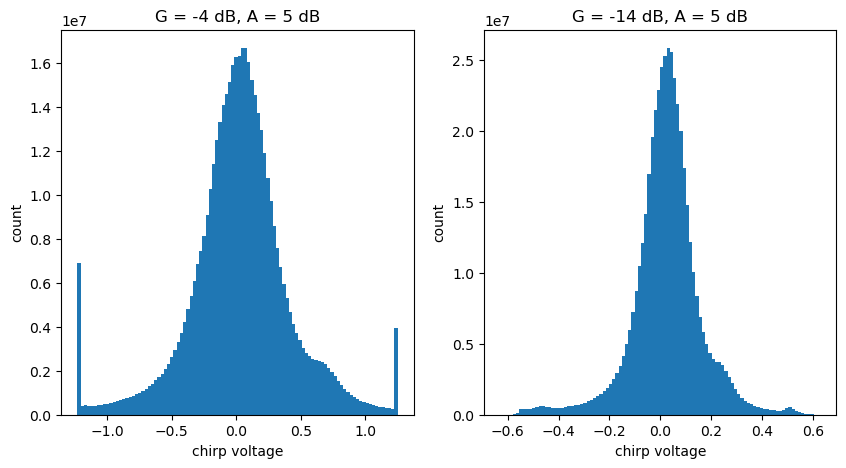

In [32]:
plot_hist(ds_101)

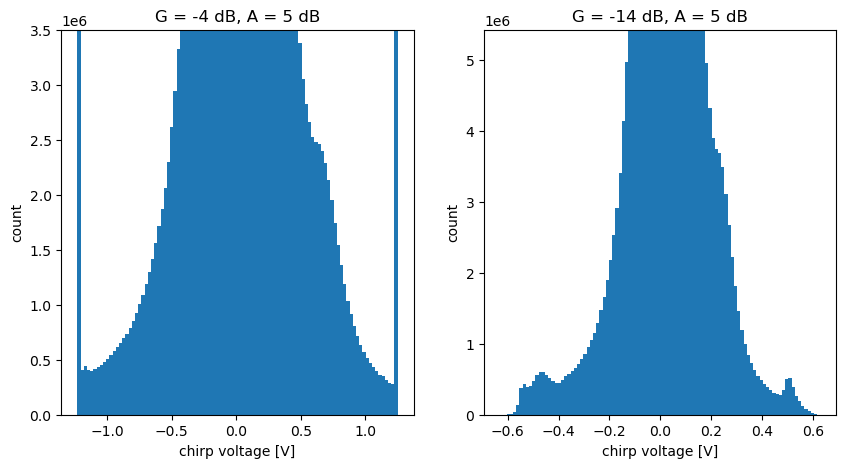

In [35]:
plot_hist(ds_101,ylim=True)

We see that the first attenuator/gain setting pair has definite lobes, and therefore clipping. However, we learned that if the signal is clipped under one specific attenuator setting, the same clipping artifacts appear regardless of the gain setting. So even though the second attenuator/gain setting pair doesn't have as distinct lobes (still, there are some small sidelobes), the artifacts we want to avoid still show up. We will demonstrate that with some specific clipped chirps and profiles below.

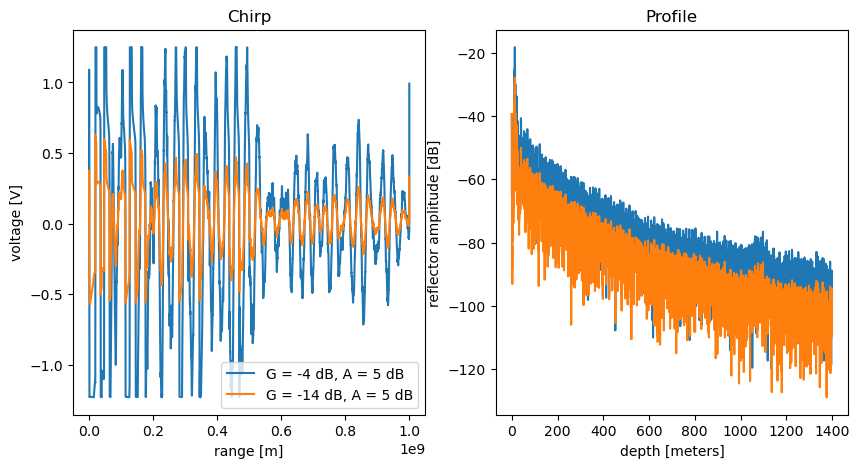

In [8]:
example_chirp = ds_101.isel(time=[7060]).compute()
plot_profile(example_chirp)

We see from above that even though the second setting doesn't reach the thresholds like the first, the resulting profiles both exhibit the same shape and weak bed signal. We can see what a chirp with less clipping looks like below, with a more proper noise floor and clear bed signal.

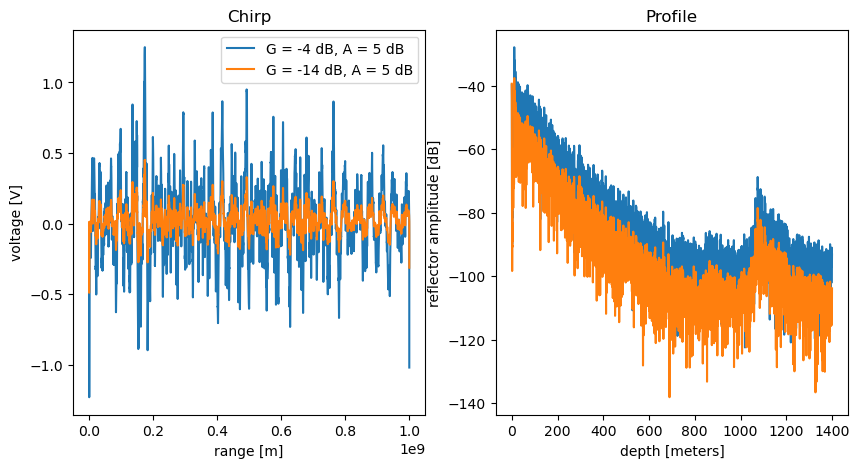

In [9]:
example_good_chirp = ds_101.isel(time=[50]).compute()
plot_profile(example_good_chirp)

Therefore, the clipping effects in this season are the same regardless of gain setting, since the attenuator setting is the same. We will proceed with using the lower gain setting for our analysis as the rest of the signal will be stronger.

To remove clipping, we recognize that the first half of the chirp in our example is where clipping occurs. Let's try applying half chirps to our examples from above and compare them to the profiles determined from the full chirp. Afterwards, we will apply this to the whole timeseries. First, let's do this with our good example to make sure the resulting profiles aren't changed by too much.

In [66]:
def custom_profile(chirps,pad=2,start=0,stop=39999):
    # This by default cuts off the last two samples
    times = chirps.chirp_time.values.astype('float64')/1e9
    regular_freq_range = 2e8+2e8*times
    start_freq = regular_freq_range[start]
    stop_freq = regular_freq_range[stop-1]
    B = stop_freq - start_freq
    CentreFreq = B/2
    K = 2e8 # determined from step-up freq (5000 Hz) and step-up time (2.5e-5)
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = times[start]
    T1 = times[stop-1]

    chirps = chirps.isel(chirp_time=range(start,stop)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    print(Nt)
    Nt = math.floor(Nt/2) * 2
    print(Nt)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

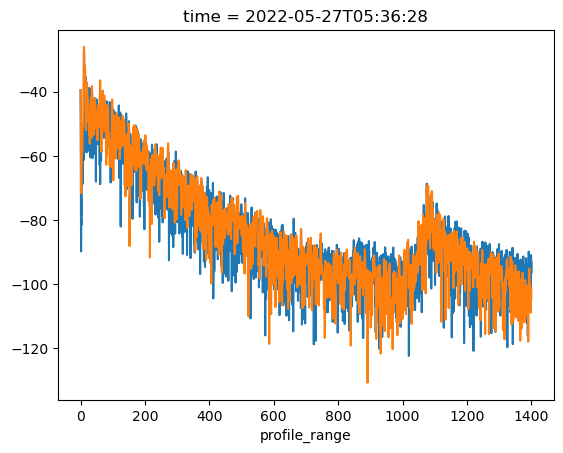

In [64]:
xa.dB(example_good_chirp.isel(attenuator_setting_pair = 0).profile_stacked).plot()
test = custom_stacked_profile_series(example_good_chirp.chirp.isel(attenuator_setting_pair = 0),2,3e8)
xa.dB(test).plot()

39999
39998


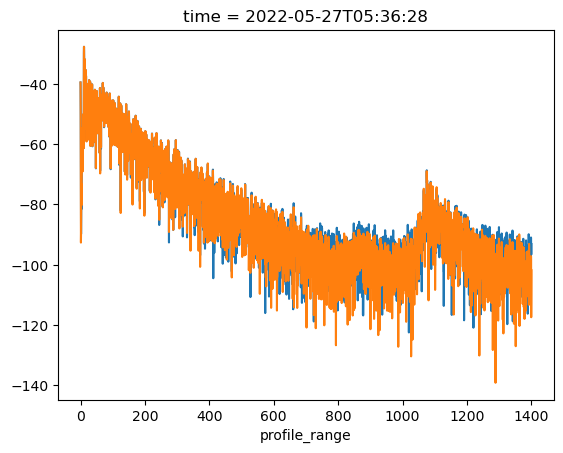

In [71]:
xa.dB(example_good_chirp.isel(attenuator_setting_pair = 0).profile_stacked).plot()
test = custom_profile(example_good_chirp.chirp.isel(attenuator_setting_pair = 0),2,0)
xa.dB(test).plot()

In [29]:
0.2*example_good_chirp.chirp.isel(attenuator_setting_pair = 0).chirp_time.values.astype('float64')

array([0.00000e+00, 5.00000e+03, 1.00000e+04, ..., 1.99990e+08,
       1.99995e+08, 2.00000e+08])

In [41]:
times = example_good_chirp.chirp.isel(attenuator_setting_pair = 0).chirp_time.values.astype('float64')/1e9
times[40001]

IndexError: index 40001 is out of bounds for axis 0 with size 40001

We see that although there are some obvious differences, the bed reflector is still preserved, as is the overall shape. The differences help emphasize that to keep our analysis consistent across a season, we should apply this partial-waveform across all the data. Now let's do this with the clipped data

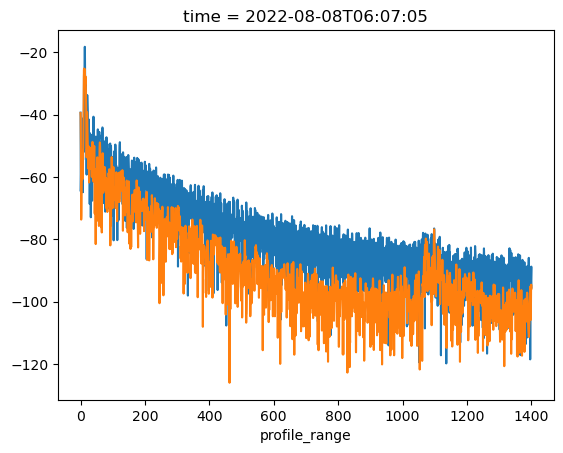

In [85]:
xa.dB(example_chirp.isel(attenuator_setting_pair = 0).profile_stacked).plot()
test = custom_stacked_profile_series(example_chirp.chirp.isel(attenuator_setting_pair = 0),2,3e8,4e8)
xa.dB(test).plot()

We see a much more drastic change. The noise floor is much lower, and the bed is clearer, meaning that we have removed the clipping artifacts. We can now apply this to the entire season. To identify what portion of the waveform to use, we can look at the maximum absolute value in voltage across each chirp combined. We also look at trends between chir[s within a burst, and across a season.

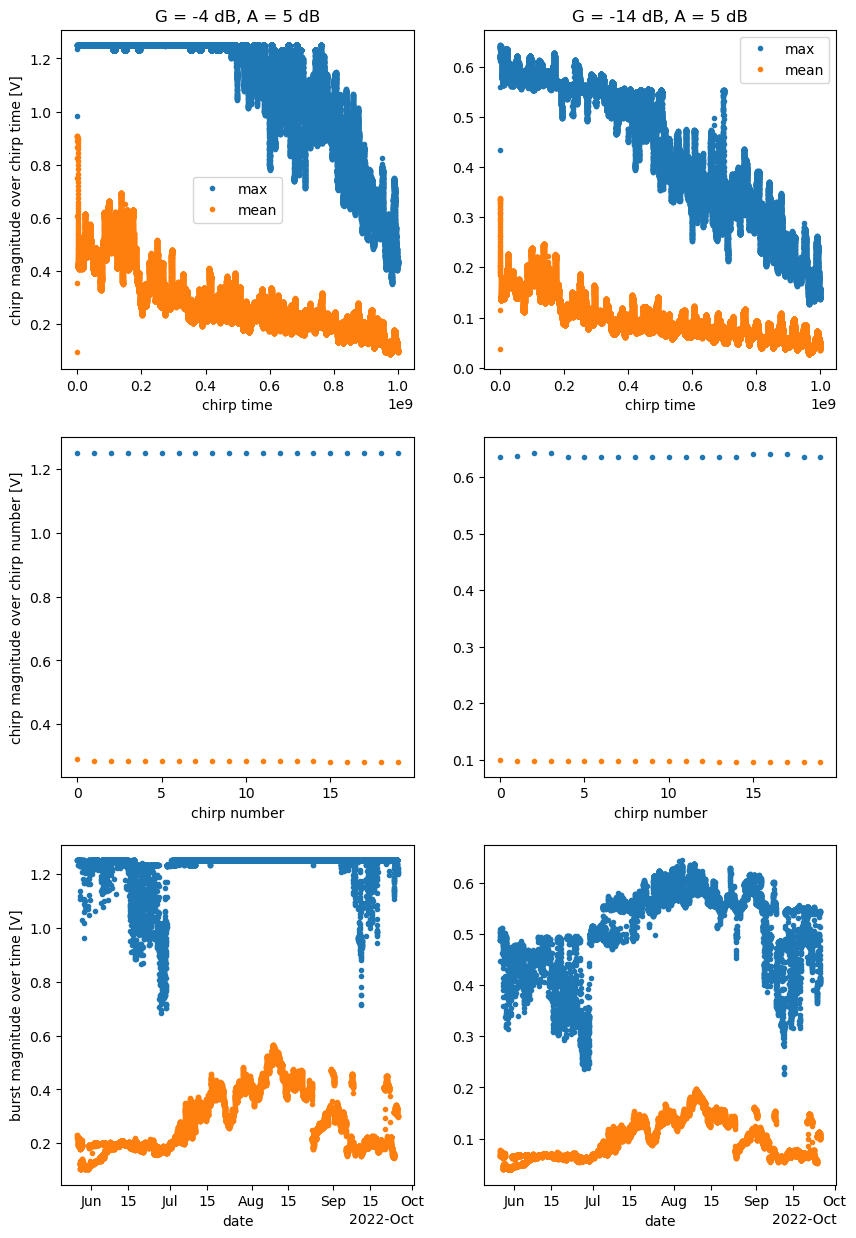

In [16]:
plot_amplitude_trends(ds_101)

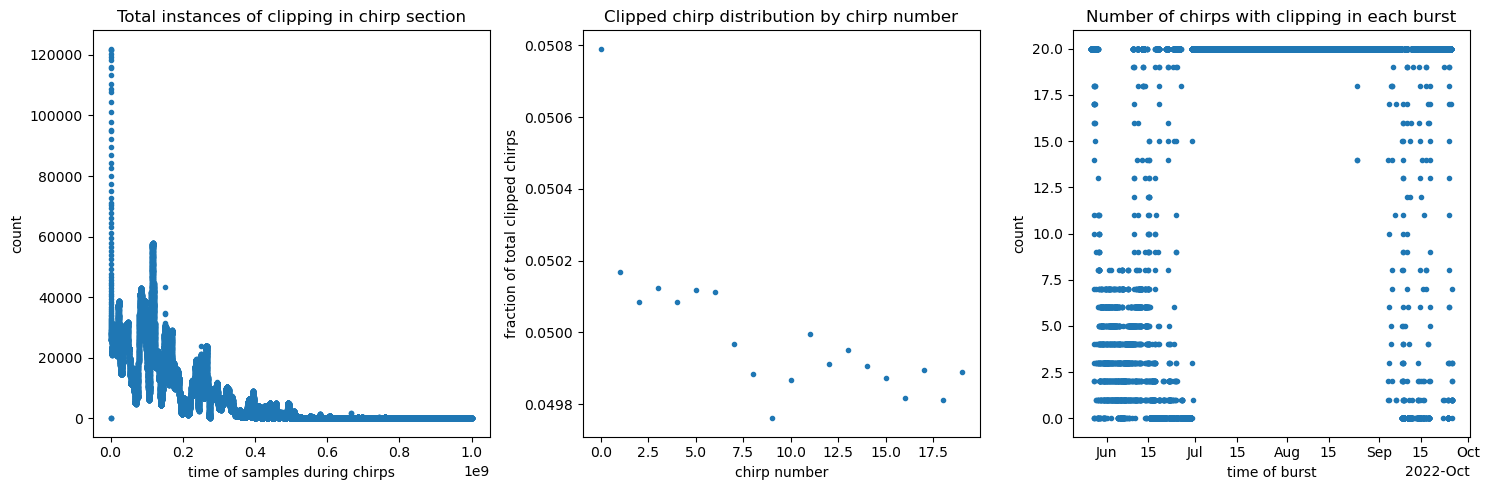

In [23]:
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

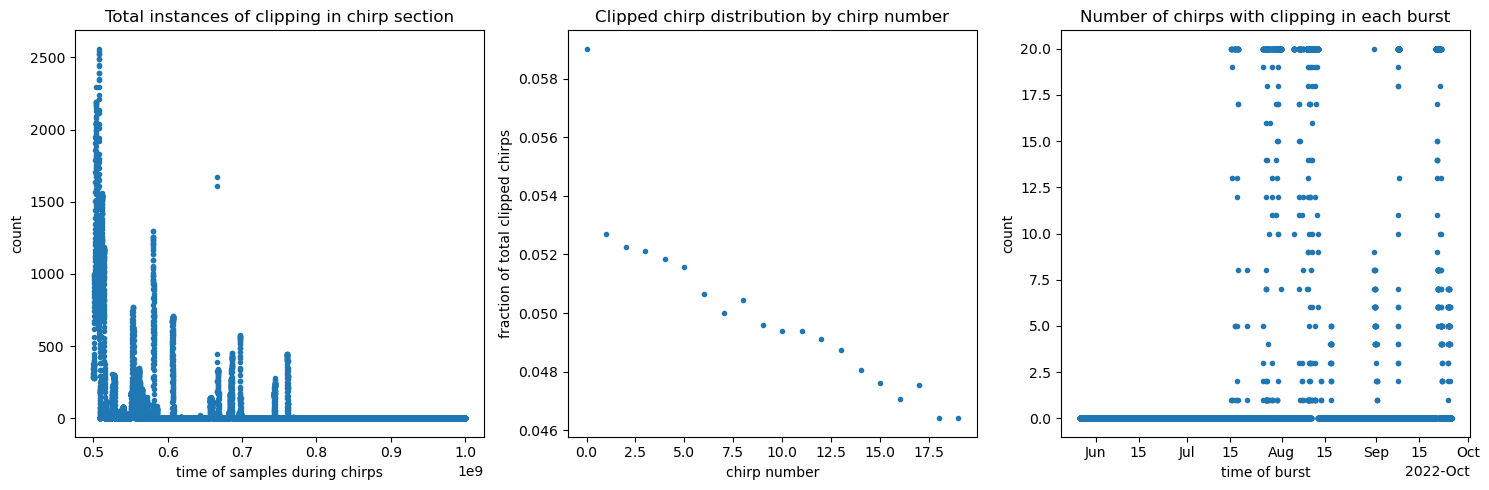

In [47]:
# half waveform
bad_chirp_condition = abs(ds_101.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

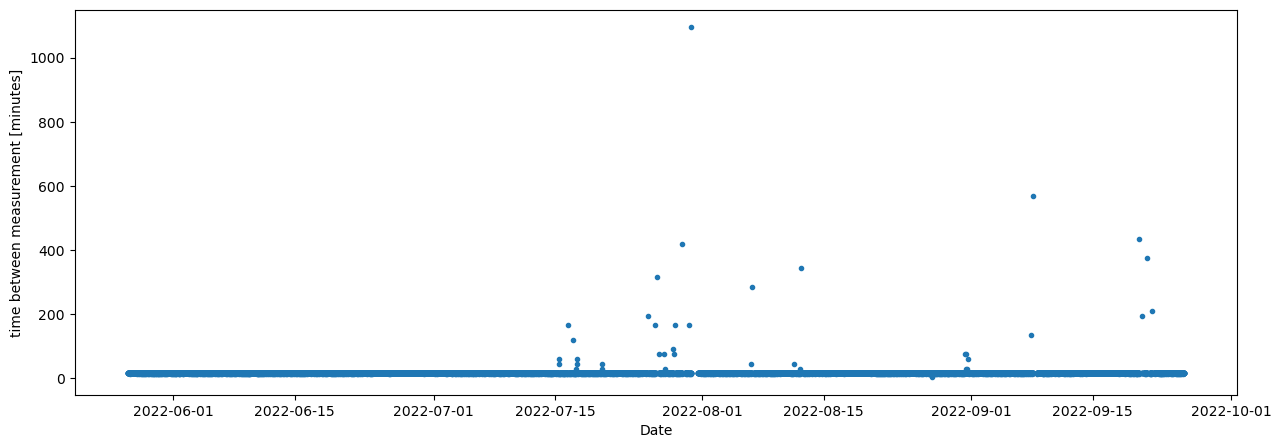

In [36]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_101.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_101.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

In [11]:
np.mean(np.diff(good_bursts.chirp.time.values))/1e9

numpy.timedelta64(930,'ns')

Based off the above plot, a safe cutoff would be retaining just the last 25% of each chirp. Let's see what the resulting histograms would be if we did that.

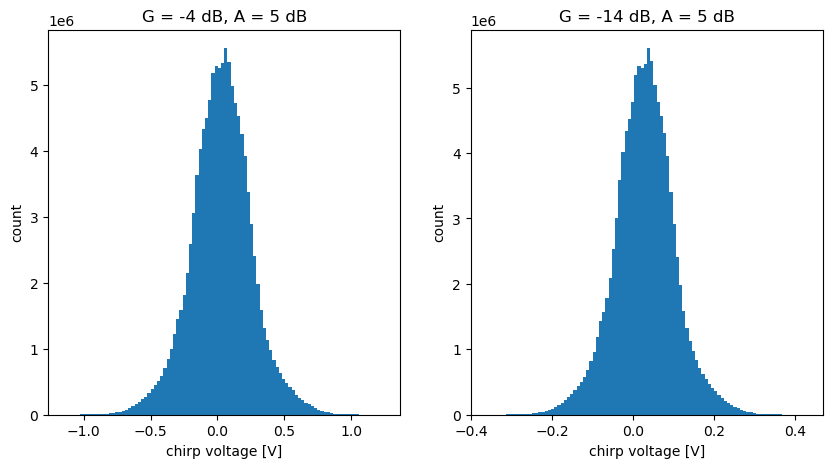

In [99]:
plot_hist(ds_101.isel(chirp_time=range(30000,40001)))

They look much nicer! Now, let's plot the before and after across the season. 

In [3]:
new_profile = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair = 0),2,3e8,4e8)

NameError: name 'ds_101' is not defined

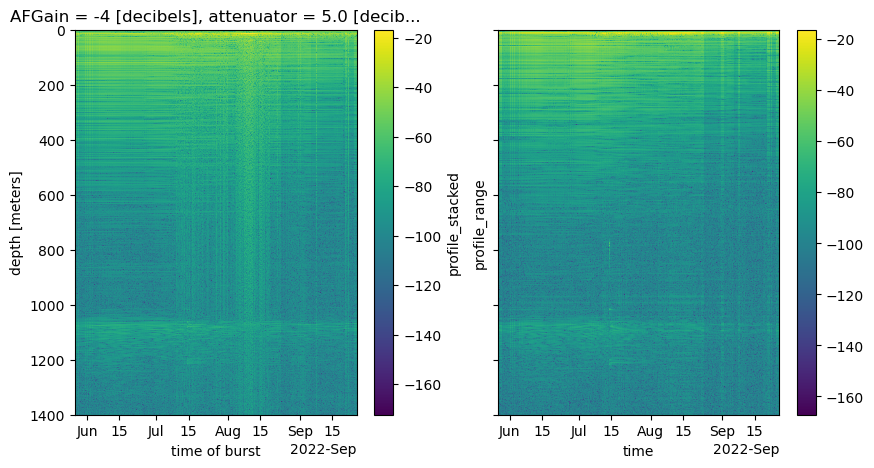

In [91]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5),sharex=True,sharey=True)
xa.dB(ds_101.profile_stacked.isel(attenuator_setting_pair=0)).plot(ax=axs[0],x='time')
xa.dB(new_profile).plot(ax=axs[1],x='time')
axs[0].invert_yaxis()

Much less streaky! There is albeit still some sudden changes in reflector strength, especially with September, but those aren't associated with clipping. It may be due to changes in surface conditions that show up as changes across the whole profile. We will now continue with the remaining seasons and stations. For each, we will use the histograms to identify if there is clipping, and then we will plot the maximum waveform magnitude to determine a cutoff for our chirp window, if needed.

Also note that these cuts are for the entire season. For investigating lake drainage dynamics, we will apply this methodology to only a relevant snippet of data.

## Winter 2022-2023


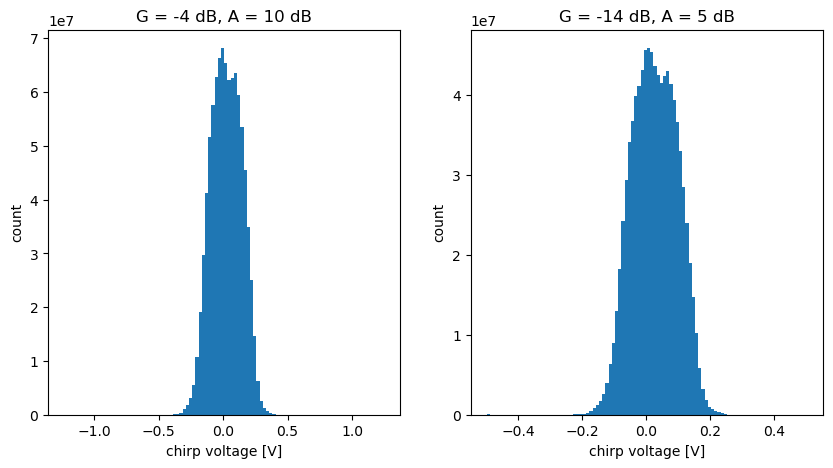

In [92]:
plot_hist(ds_101_w)

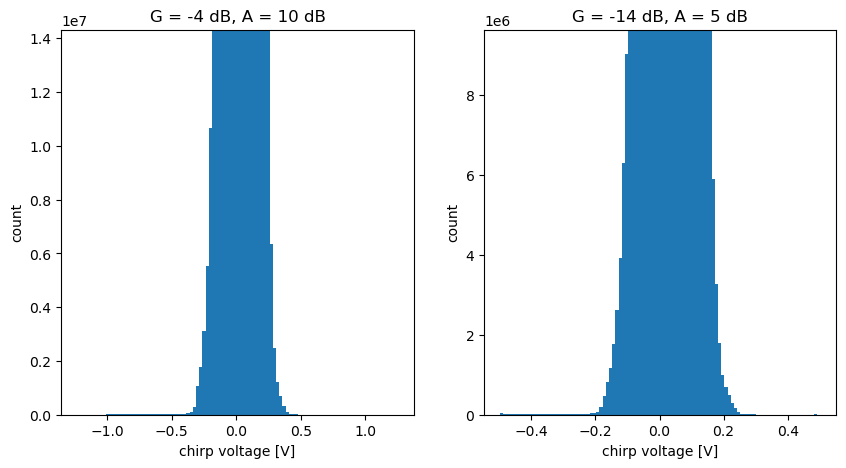

In [36]:
plot_hist(ds_101_w,ylim=True)

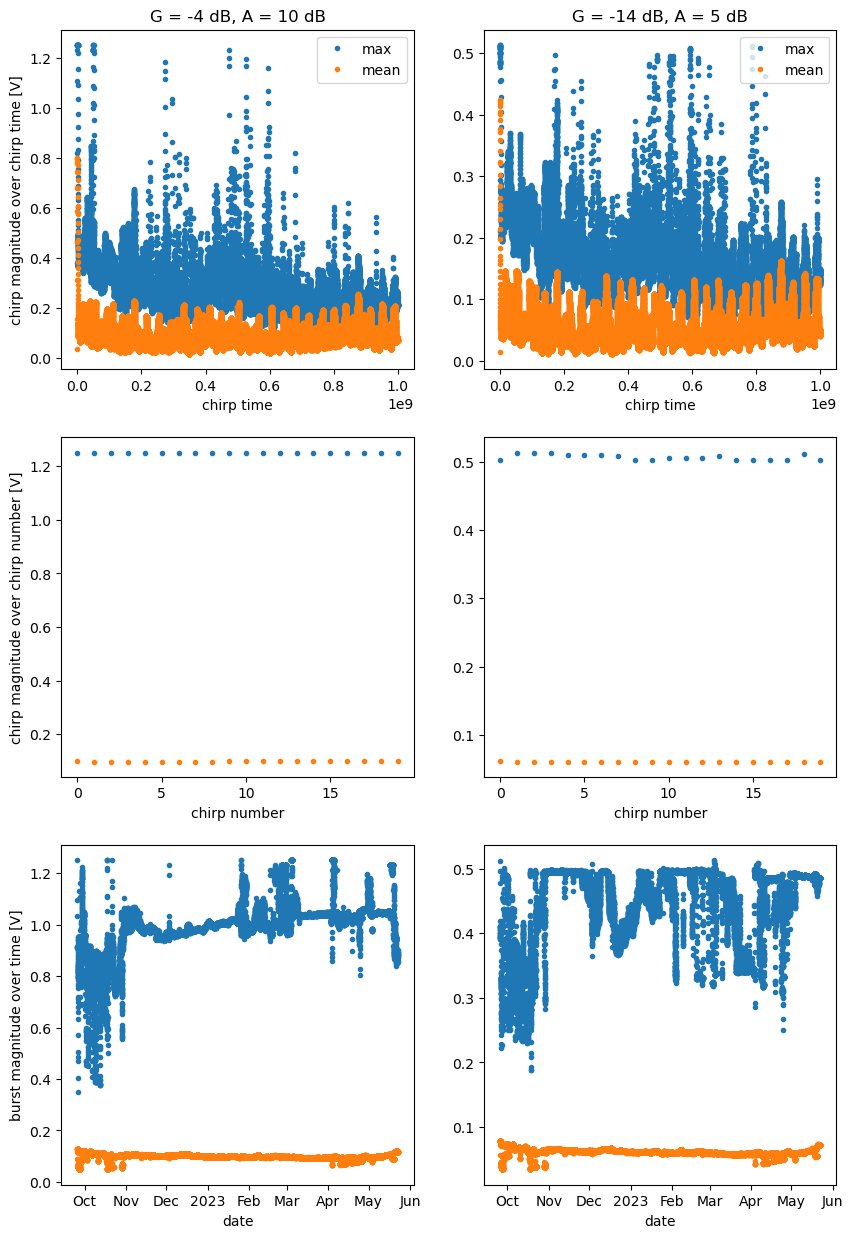

In [37]:
plot_amplitude_trends(ds_101_w)

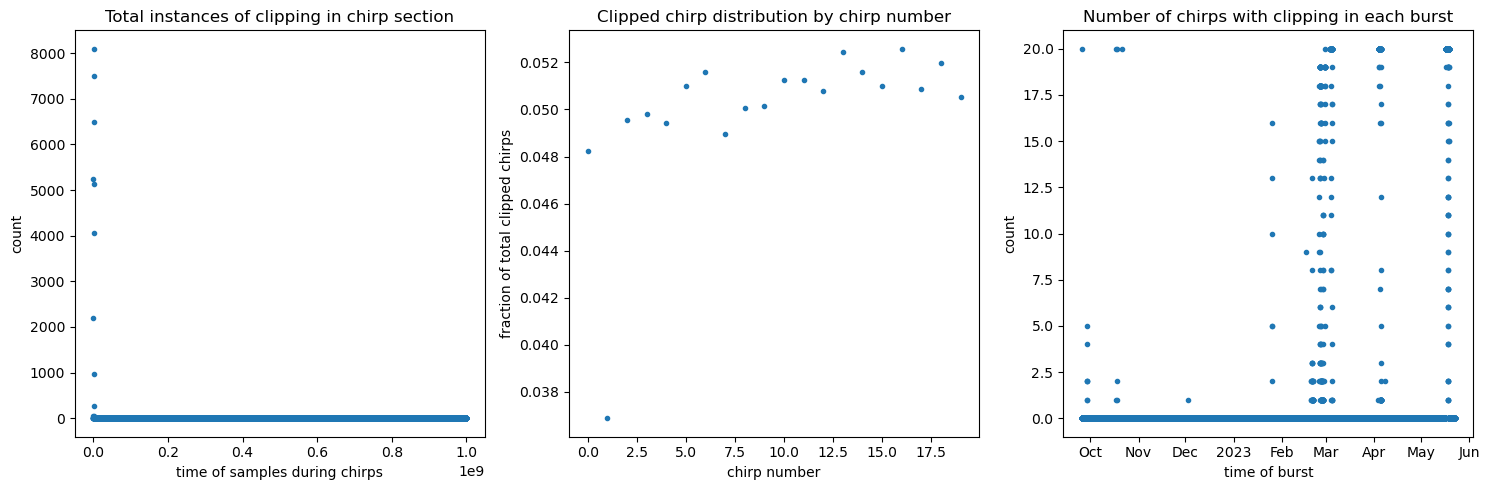

In [24]:
bad_chirp_condition = abs(ds_101_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101_w.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

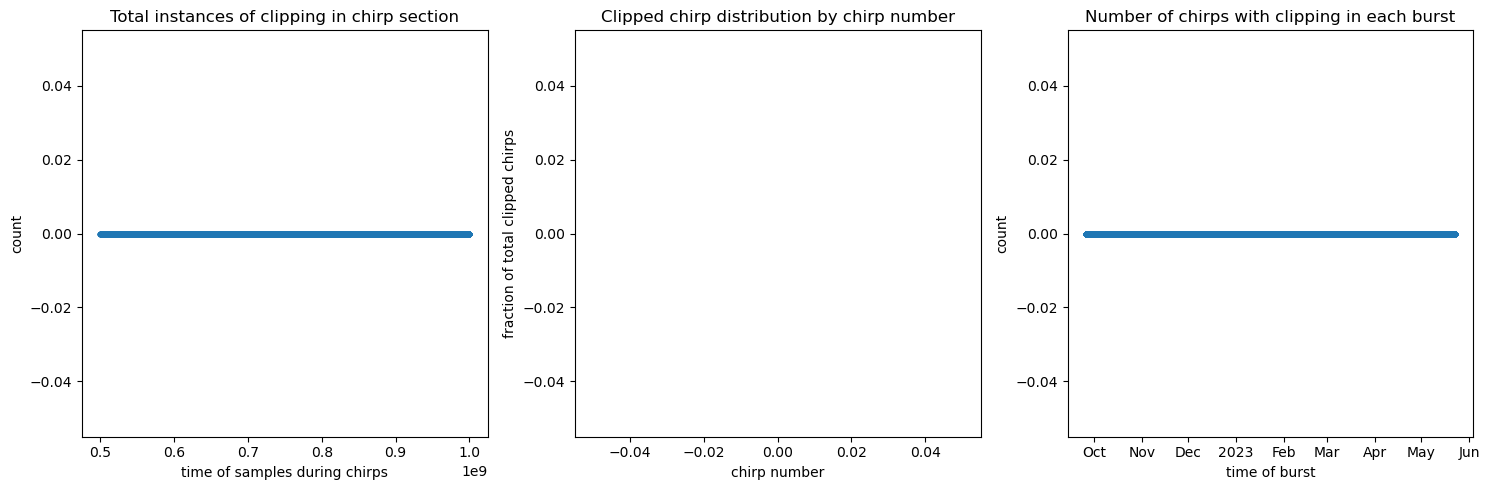

In [48]:
# half waveform
bad_chirp_condition = abs(ds_101_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_101_w.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

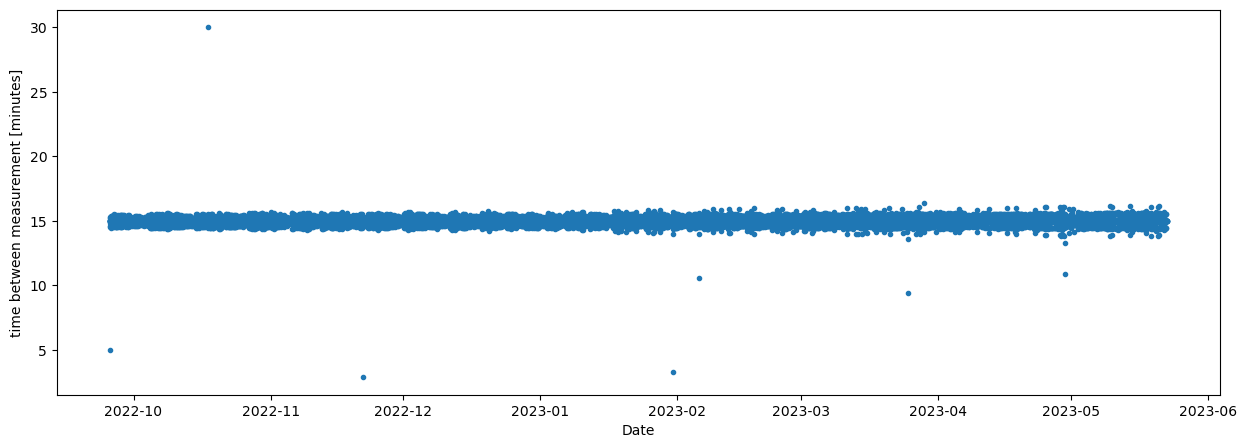

In [34]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_101_w.isel(attenuator_setting_pair=0,chirp_time=range(100,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_101_w.isel(attenuator_setting_pair=0,chirp_time=range(100,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],(np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9)/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

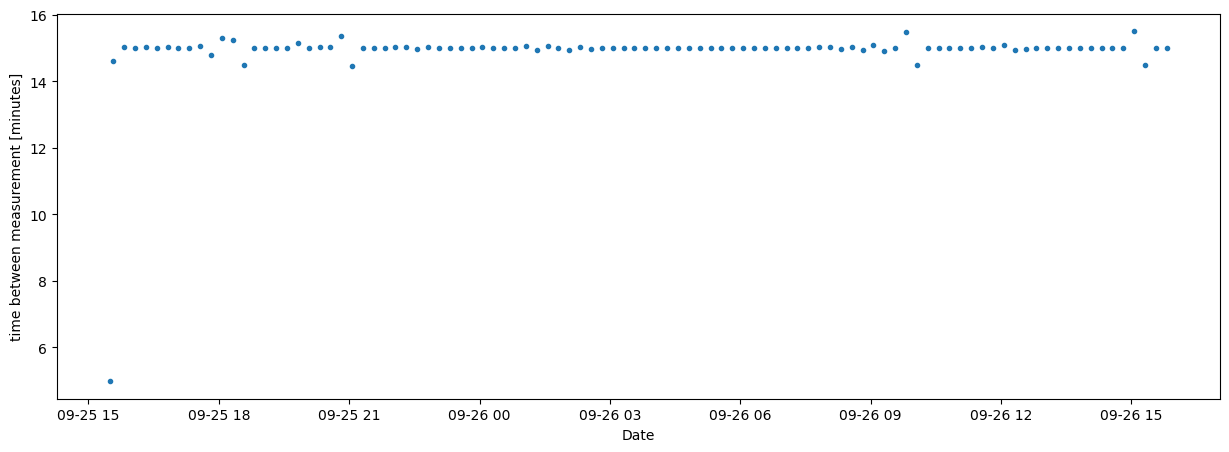

In [35]:
fig,ax = plt.subplots(figsize=(15,5))
test = good_bursts.isel(time=range(0,100))
ax.plot(test.chirp.time.values[0:-1],(np.diff(test.chirp.time.values.astype("float64"))/1e9)/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

There is little to no clipping here. Let's tru useing a half waveform anyways and see how that impacts and strain rate estimates.

In [20]:
# Repurpose another function to compare strain rate estimates based on window
def generate_strain_fit(ds,window,lag,lims=None):
    # New method
    profile = ds.profile_stacked.isel(attenuator_setting_pair=0).compute()
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    
    # Old Method
    profile = custom_stacked_profile_series(ds.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_old = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')
    vv_old = ds_old.range_diff / ds_old.time_diff * 31536000
    vv_old_err = ds_old.err / ds_old.time_diff * 31536000
    fit_old=vv_old.where(vv_old.profile_range <=600).polyfit('profile_range',1,full=True)
    r2_old = 1-fit_old.polyfit_residuals/((vv_old-vv_old.mean())**2).sum(dim='profile_range')
    
    # Plotting
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='Full chirp')
    axs[0].plot(fit_old.time.values,fit_old.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',alpha=0.2,label='Half chirp')
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[0].legend(loc="upper left", ncol=2)
    axs[0].set_ylim([-0.01, 0])

    axs[1].plot(fit.time.values,r2.values,linestyle='None',marker='.')
    axs[1].plot(fit_old.time.values,r2_old.values,linestyle='None',marker='.',alpha=0.2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    
    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv_old.time)),len(vv_old.time),len(vv_old.time)//10)
    for i in range(10):
        time = vv_old.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=1)
        axs_1[i].errorbar(vv_old.sel(time = time,method="nearest") ,vv_old.profile_range,yerr=None,xerr=vv_old_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=2)
        #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if lims:
            axs_1[i].set_xlim(lims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
    return vv,vv_err,vv_old,vv_old_err

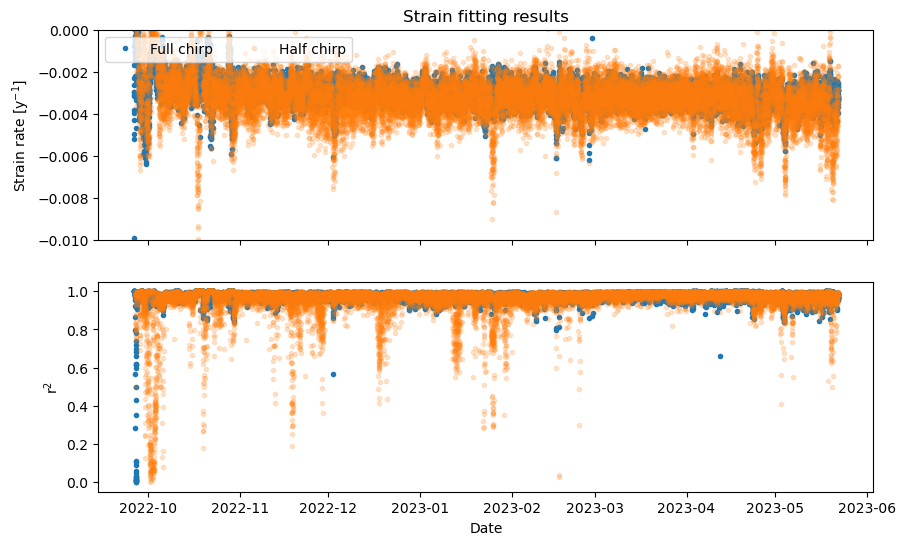

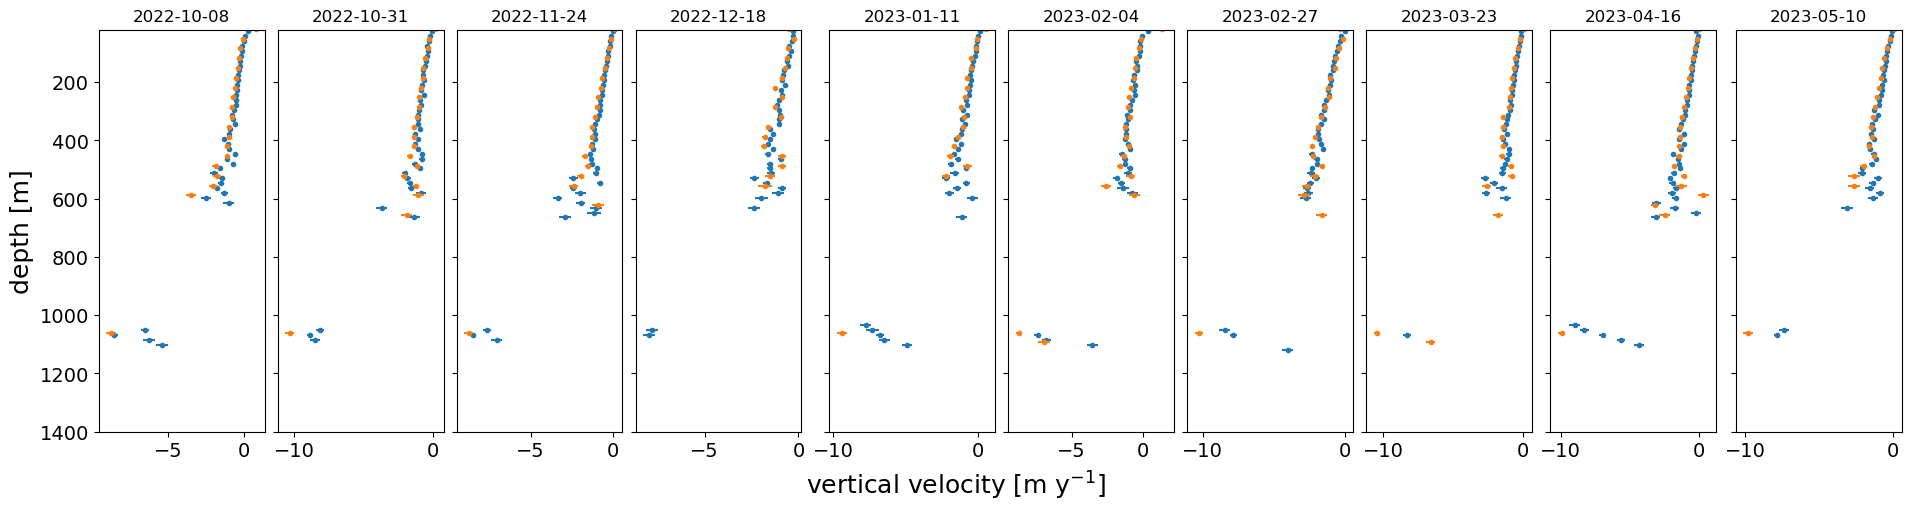

In [21]:
vv,vv_err,vv_old,vv_old_err=generate_strain_fit(ds_101_w,80,96)

Overall, seems like the estimates are fine. However, reducing the chirp covered by half is akin to reducing the resolution in depth by half. 

There is no Summer 2023 data at station A11

# A13

## Summer 2022


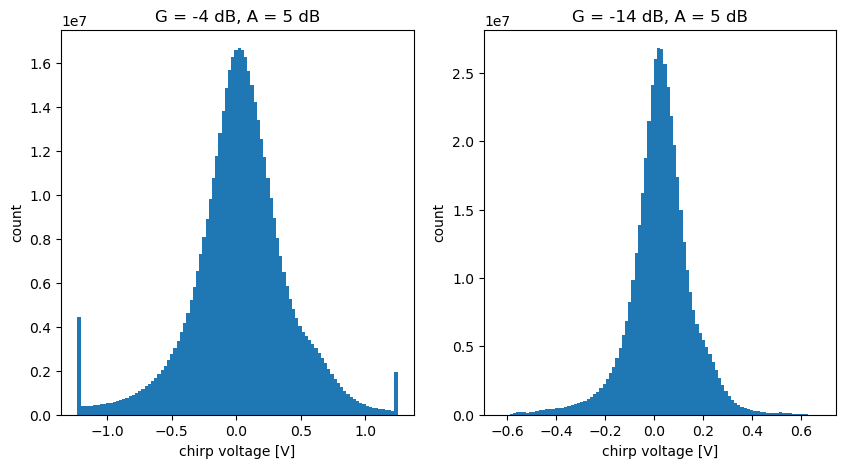

In [93]:
plot_hist(ds_103)

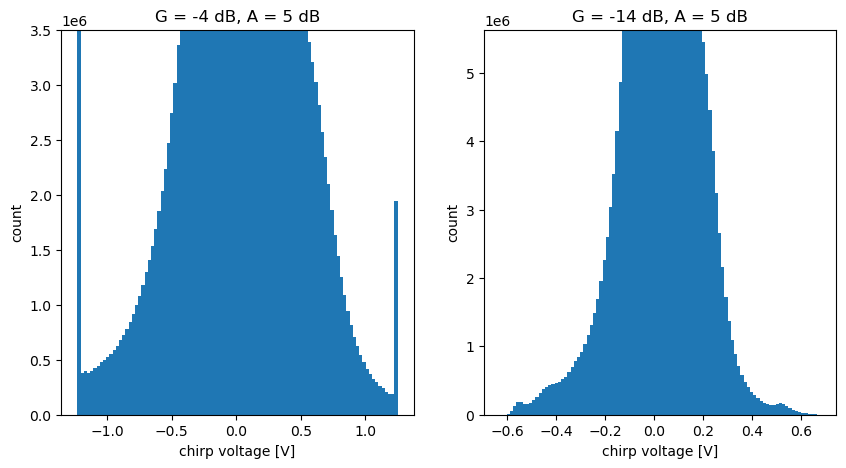

In [39]:
plot_hist(ds_103,ylim=True)

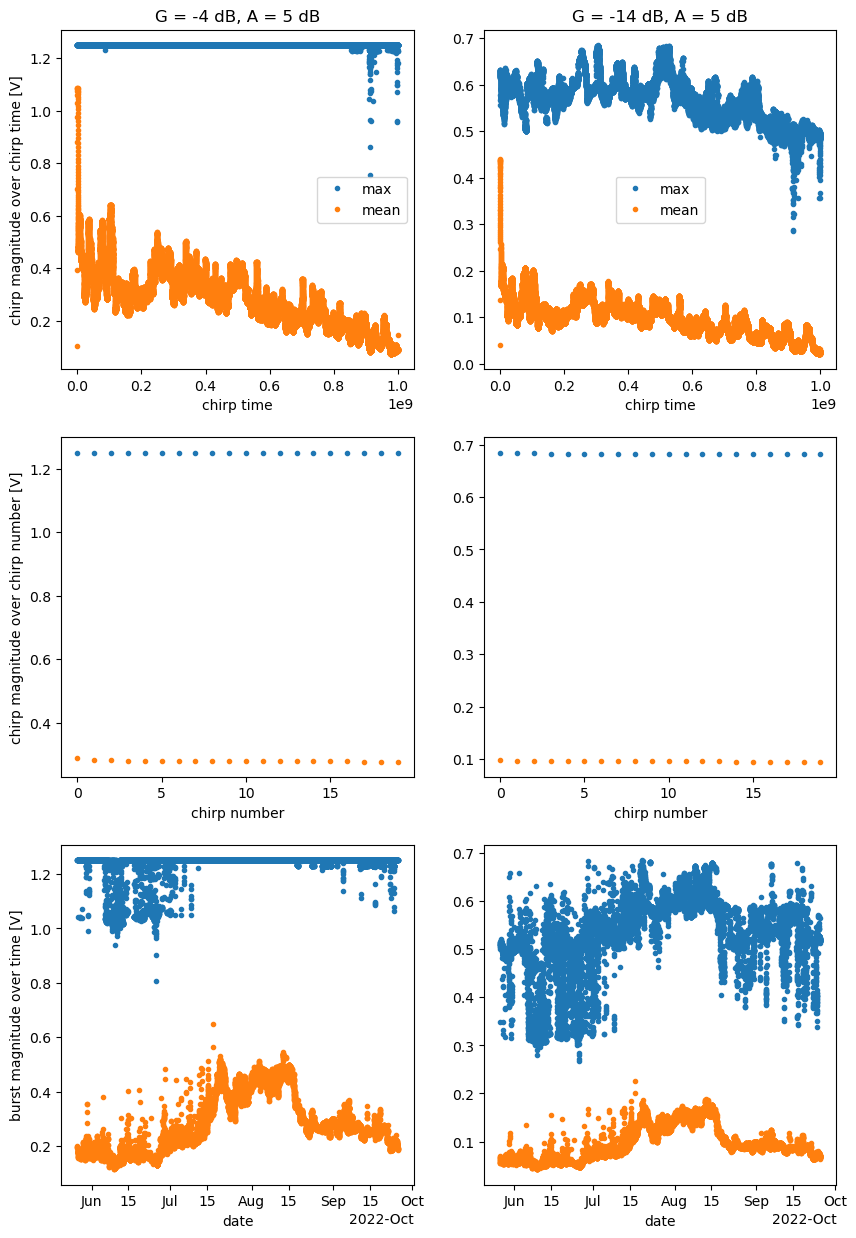

In [38]:
plot_amplitude_trends(ds_103)

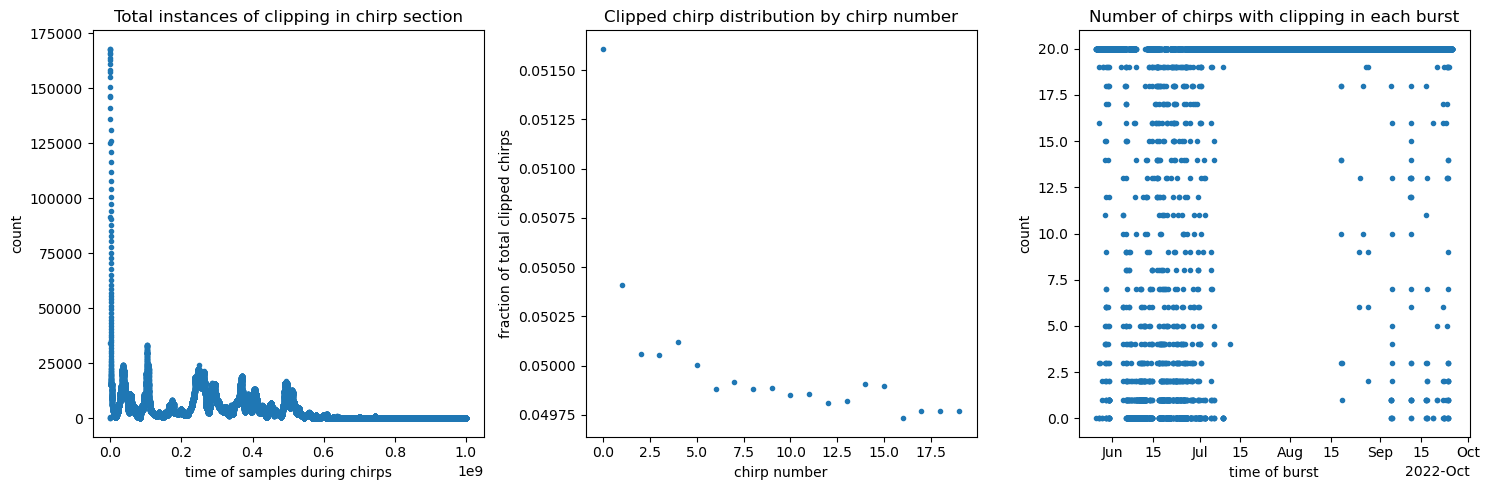

In [33]:
bad_chirp_condition = abs(ds_103.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

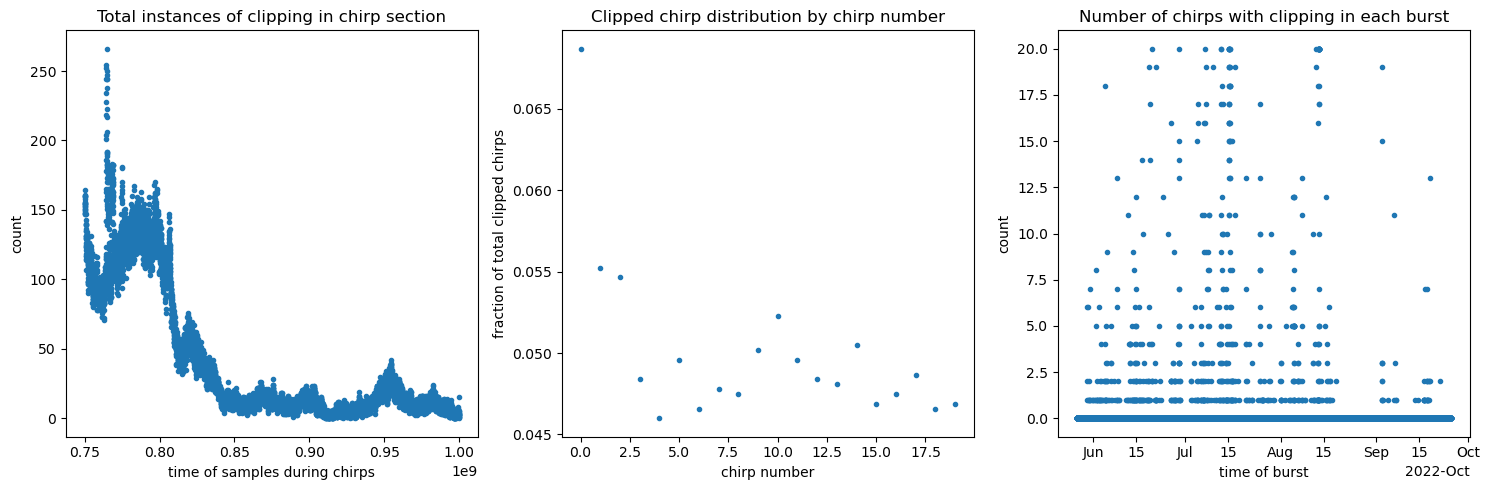

In [7]:
# quarter waveform
bad_chirp_condition = abs(ds_103.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103.isel(attenuator_setting_pair=0,chirp_time=range(30000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

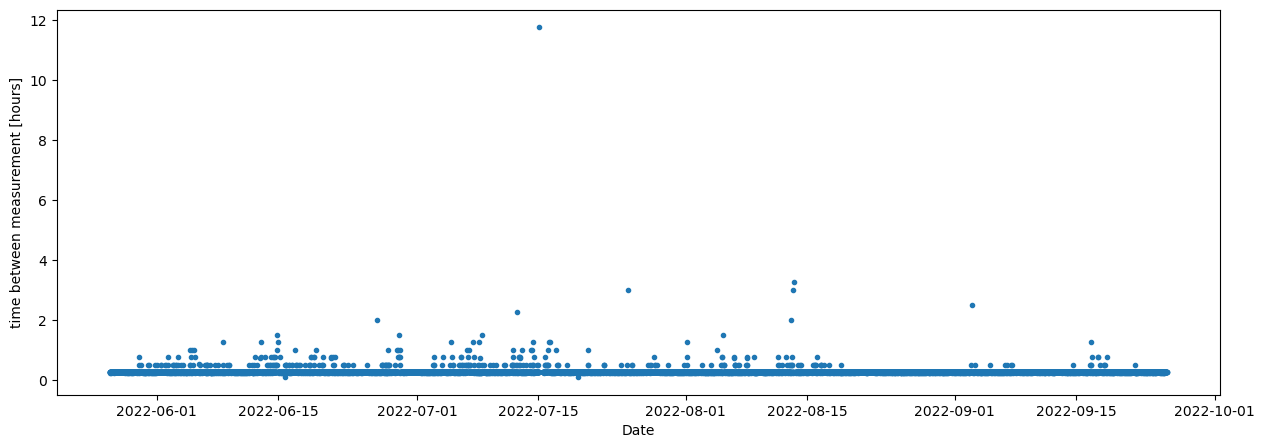

In [6]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_103.isel(attenuator_setting_pair=0,chirp_time=range(30000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_103.isel(attenuator_setting_pair=0,chirp_time=range(30000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/3600,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [hours]')
ax.set_xlabel('Date')

With half there is a 50 hour gap, with quarter there is a 12 hour gap at max

It's more likely that the first chirps in a burst are clipped. 

Let's maybe find criteria to discard the worst chirps. This is a balance between maintaining a good timeseries versus being able to use more of the chirp. I choose to avoid creating too many timegaps. So given that I am willing to discard up to 75% of the chirp, maybe we eliminate the bursts containing chirps that have clipping in that section. This is given by the following condition.

In [12]:
new_profile = custom_stacked_profile_series(ds_103.isel(attenuator_setting_pair=0,time=condition).chirp,2,3.5e8,4e8)

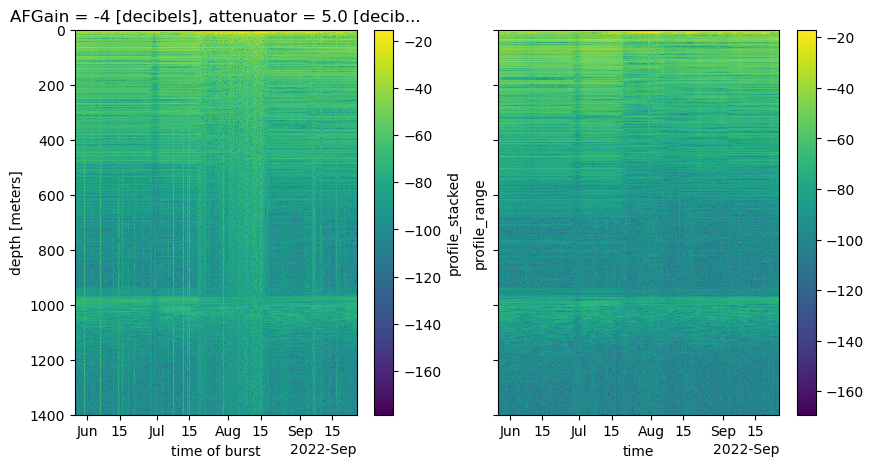

In [13]:
fig, axs = plt.subplots(ncols=2,figsize=(10,5),sharex=True,sharey=True)
xa.dB(ds_103.profile_stacked.isel(attenuator_setting_pair=0)).plot(ax=axs[0],x='time')
xa.dB(new_profile).plot(ax=axs[1],x='time')
axs[0].invert_yaxis()

Looks much better, but still a few drastic streaks. Also a very defined transition mid July.

## Winter 2022-2023

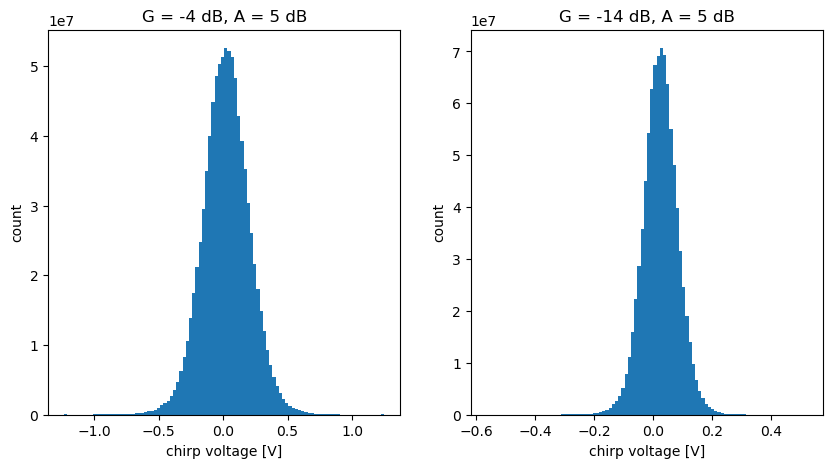

In [35]:
plot_hist(ds_103_w)

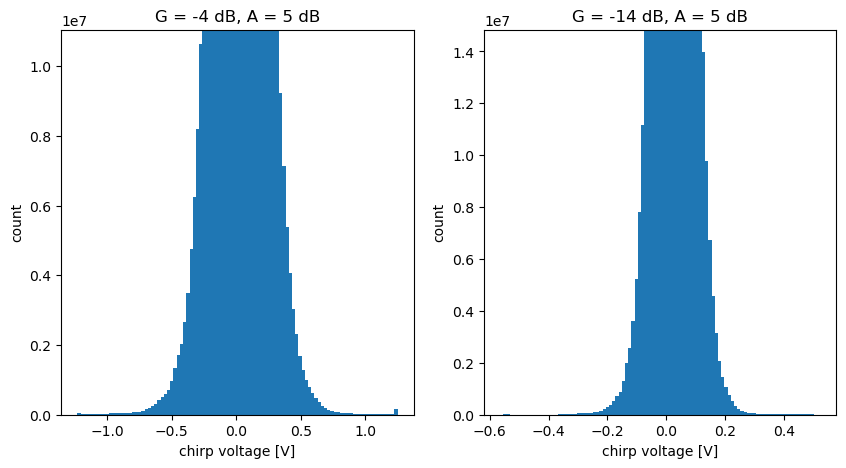

In [40]:
plot_hist(ds_103_w,ylim=True)

Looks fine, maybe a tiny bit clipped. Let's look at the max value attained across each chirp.

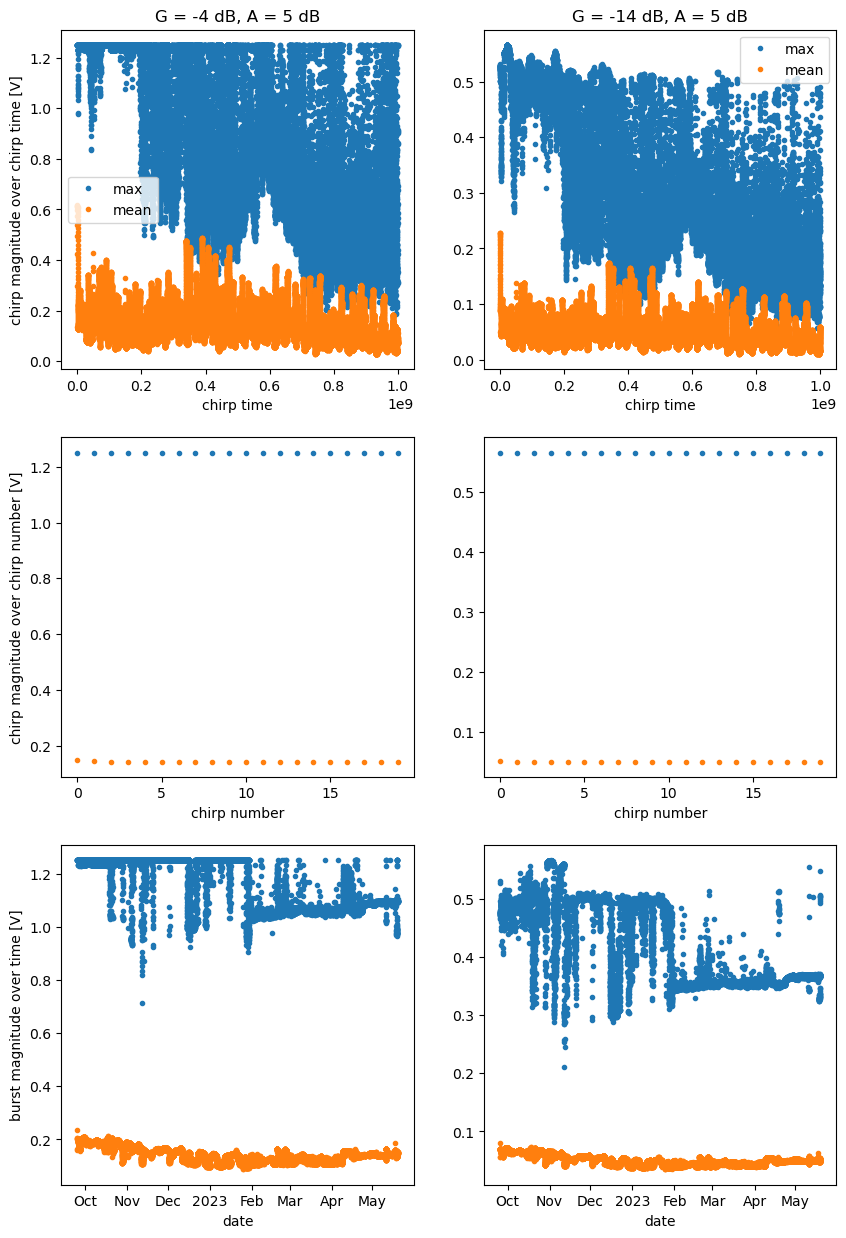

In [13]:
plot_amplitude_trends(ds_103_w)

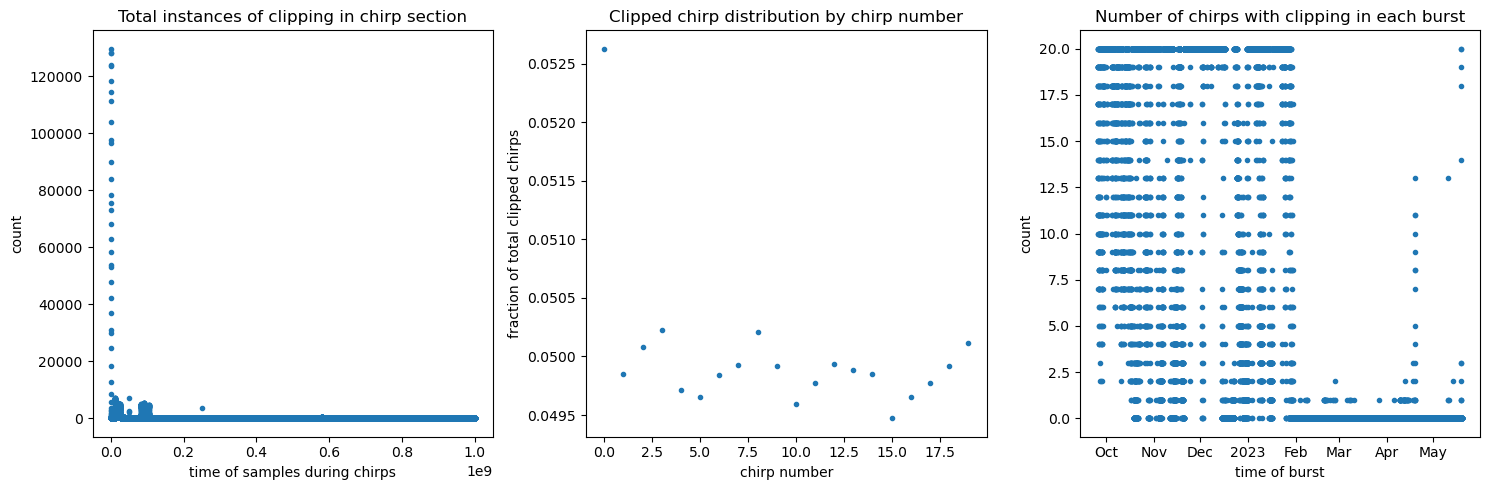

In [25]:
bad_chirp_condition = abs(ds_103_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103_w.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

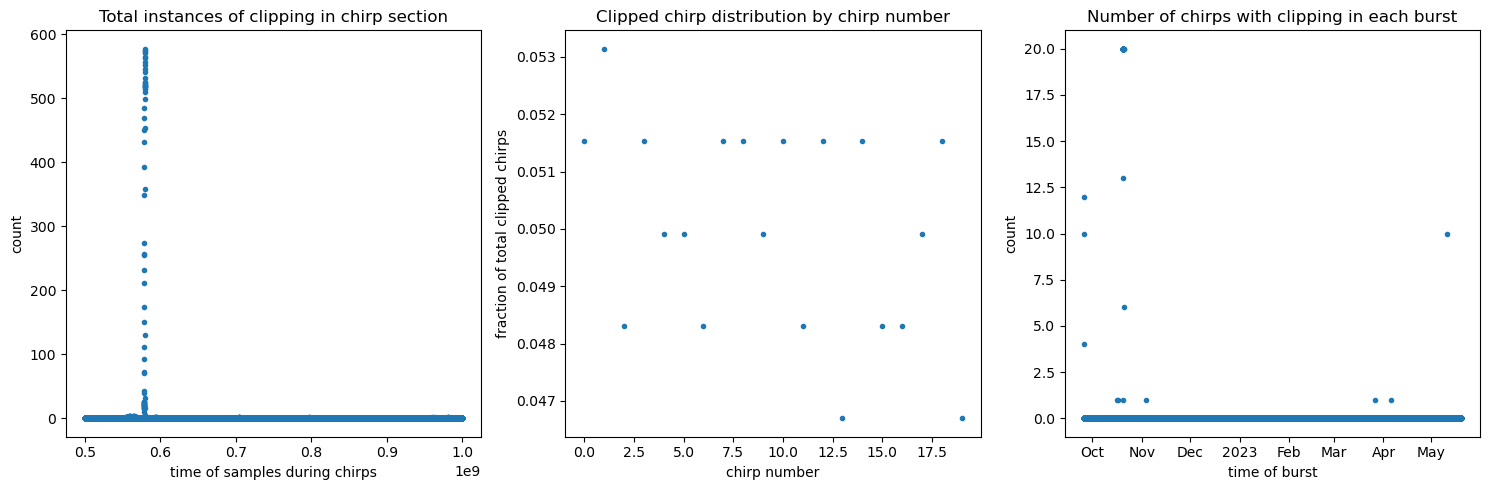

In [50]:
# half waveform
bad_chirp_condition = abs(ds_103_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103_w.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

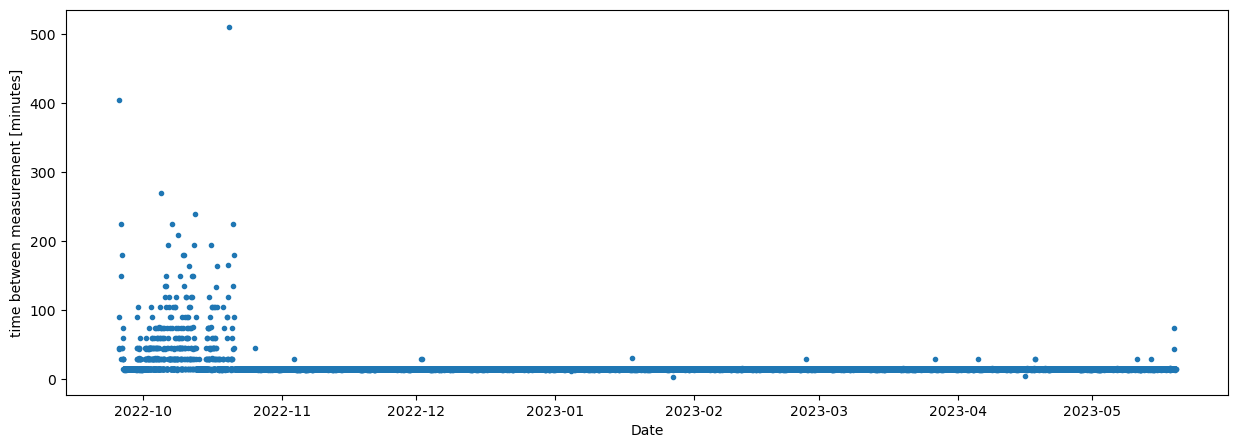

In [38]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_103_w.isel(attenuator_setting_pair=0,chirp_time=range(10000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_103_w.isel(attenuator_setting_pair=0,chirp_time=range(10000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

Seems like the shape of each chirp isn't front heavy like in the summer, so no point applying a smaller window. Let's try ignorning the first chirp and discarding bursts with high amplitudes (over 0.21 RMS V)

In [6]:
condition = abs(ds_103_w.isel(attenuator_setting_pair = 0).chirp).mean(dim=['chirp_num','chirp_time']).compute() < 0.2


In [7]:
test = ds_103_w.chirp.sel(time=condition)#.isel(chirp_num=range(1,20))
print(f"{len(ds_103_w.chirp.time)-len(test)} bursts dropped. That is about {int(100*(len(ds_103_w.chirp.time)-len(test))/len(ds_103_w.chirp.time))}% of bursts.")
print(f"Mean dt is about {int(int(np.mean(np.diff(test.time.values)))/1e9)} s.")
print(f"Longest time gap is about {int(int(np.max(np.diff(test.time.values)))/1e9 / 3600)} hours.")


282 bursts dropped. That is about 1% of bursts.
Mean dt is about 911 s.
Longest time gap is about 18 hours.


Dropping those few bursts fixes the data well enough. Only in very small portions is there any clipping. 

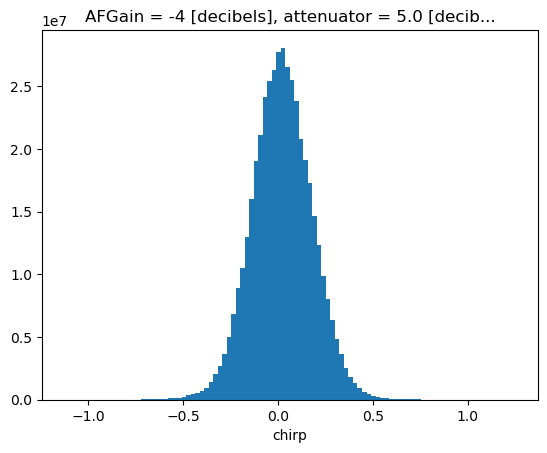

In [13]:
plot_test = test.isel(attenuator_setting_pair = 0,chirp_time=range(20000,40001),chirp_num=range(1,20)).mean(dim='chirp_num').plot.hist(bins=100)

Still a couple clipped points. Might have to make do.

## Summer 2023
This one has a lot of data.

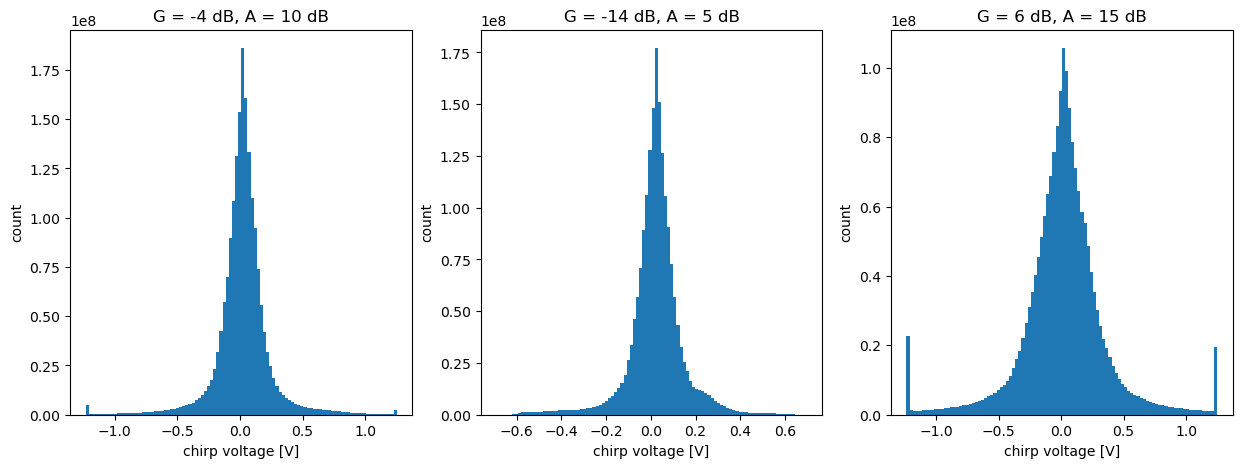

In [5]:
plot_hist(ds_103_s)

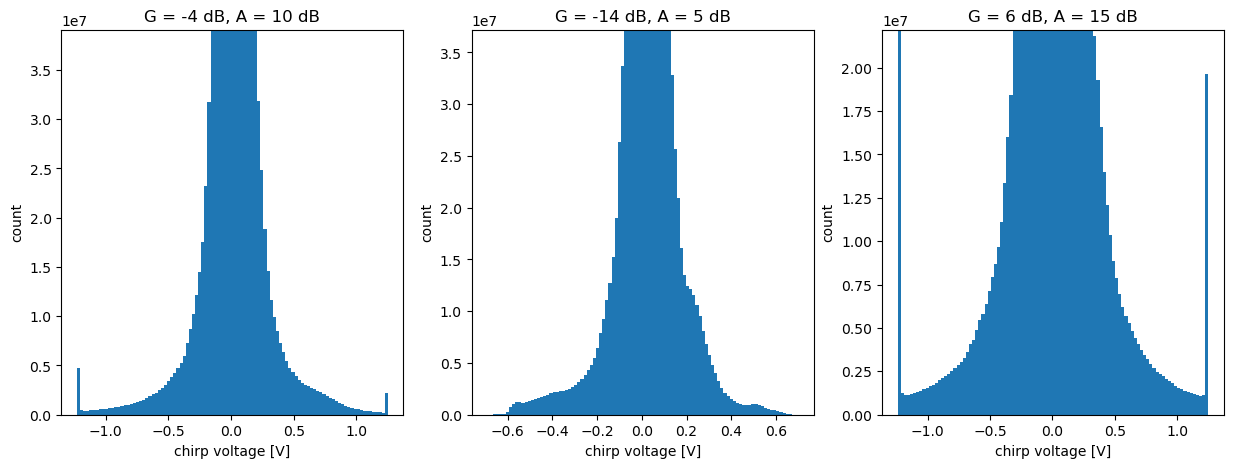

In [41]:
plot_hist(ds_103_s,ylim=True)

It looks like the middle plot has no clipping. However, given that the stronger attenuation settings both have clipping, and we saw from our A11 data that that's what matters, we can assume that the signal contains clipping artifacts across all settings. We use the highest attenuation settings in our calculations because that has the widest spread, and the clipping is the most obvious (and therefore most easy to remove).

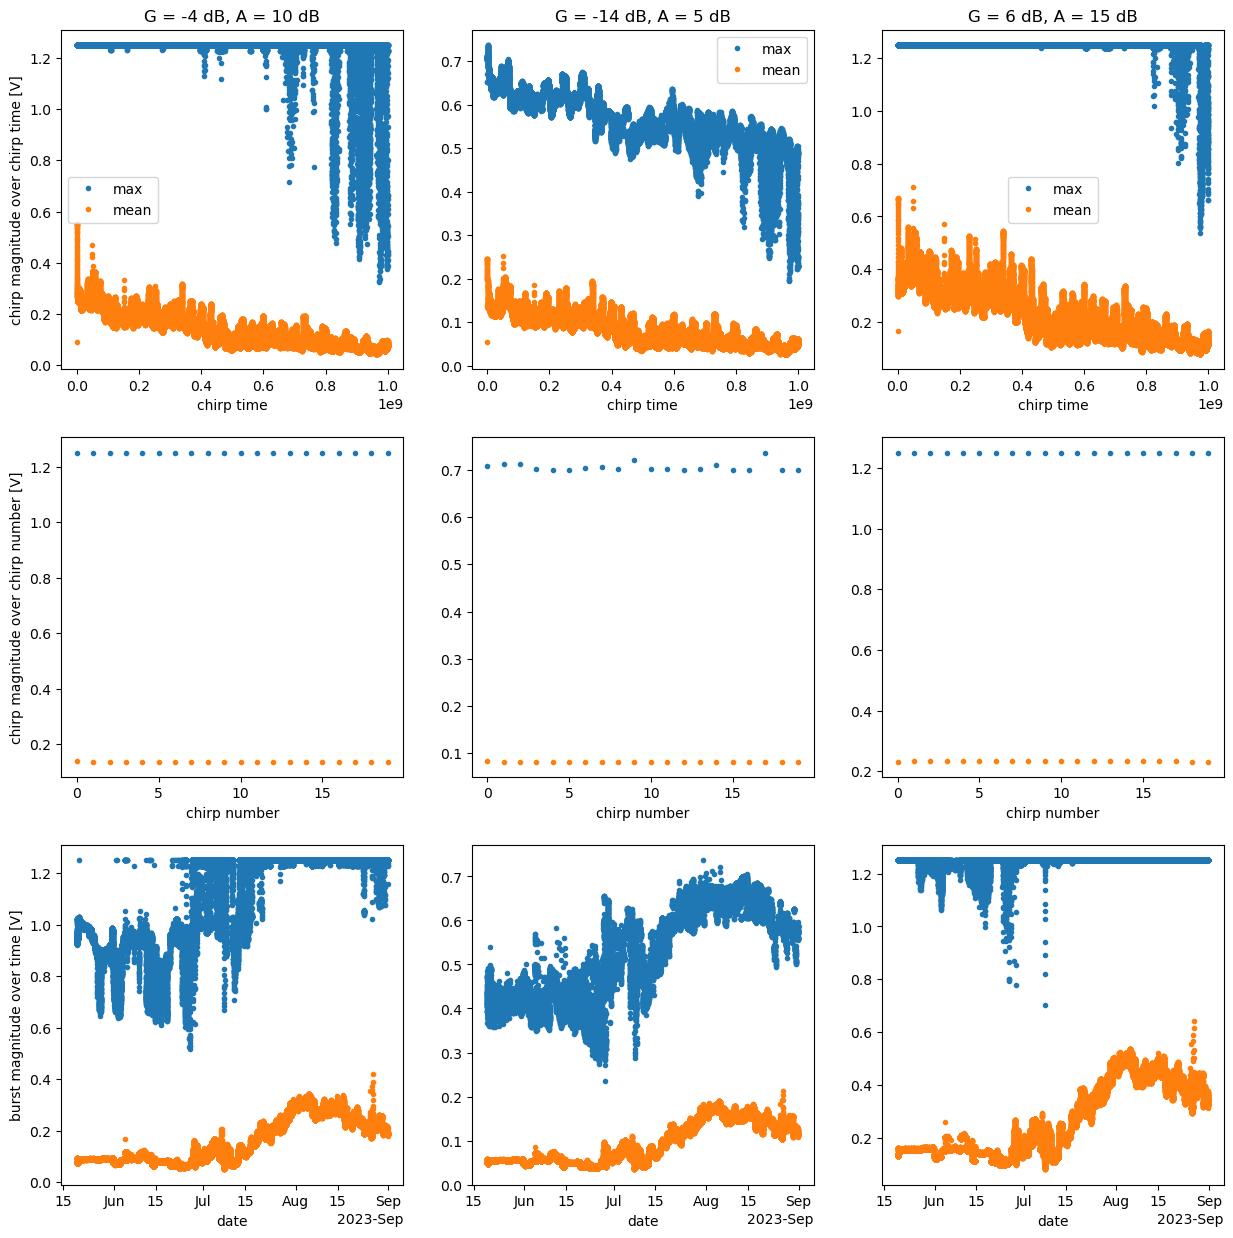

In [15]:
plot_amplitude_trends(ds_103_s)

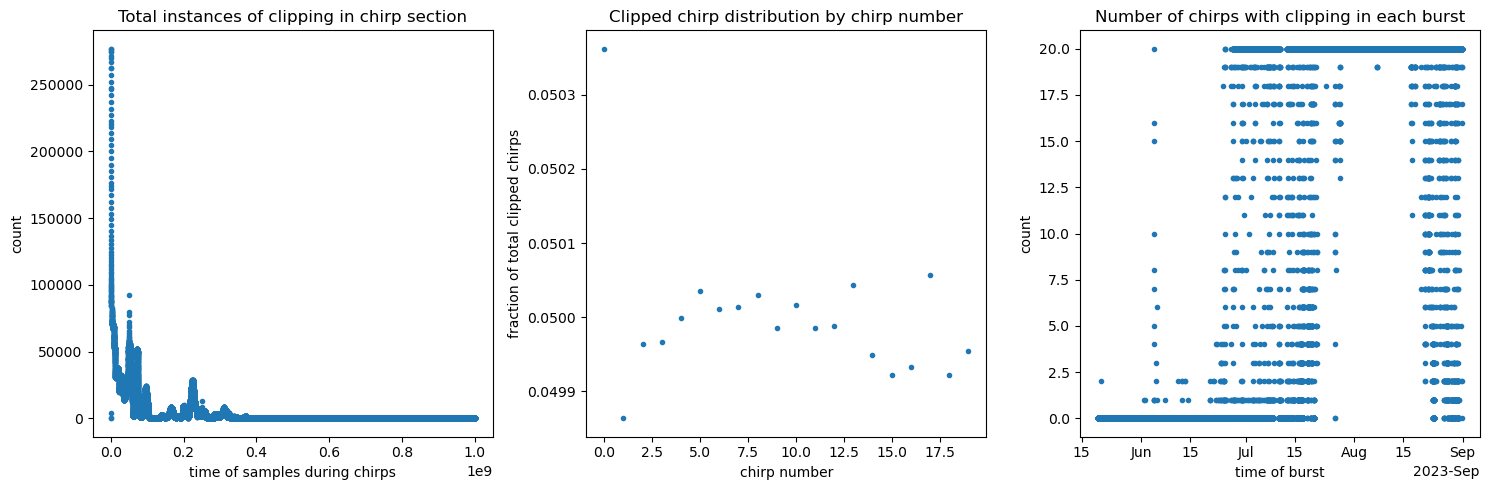

In [26]:
bad_chirp_condition = abs(ds_103_s.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103_s.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

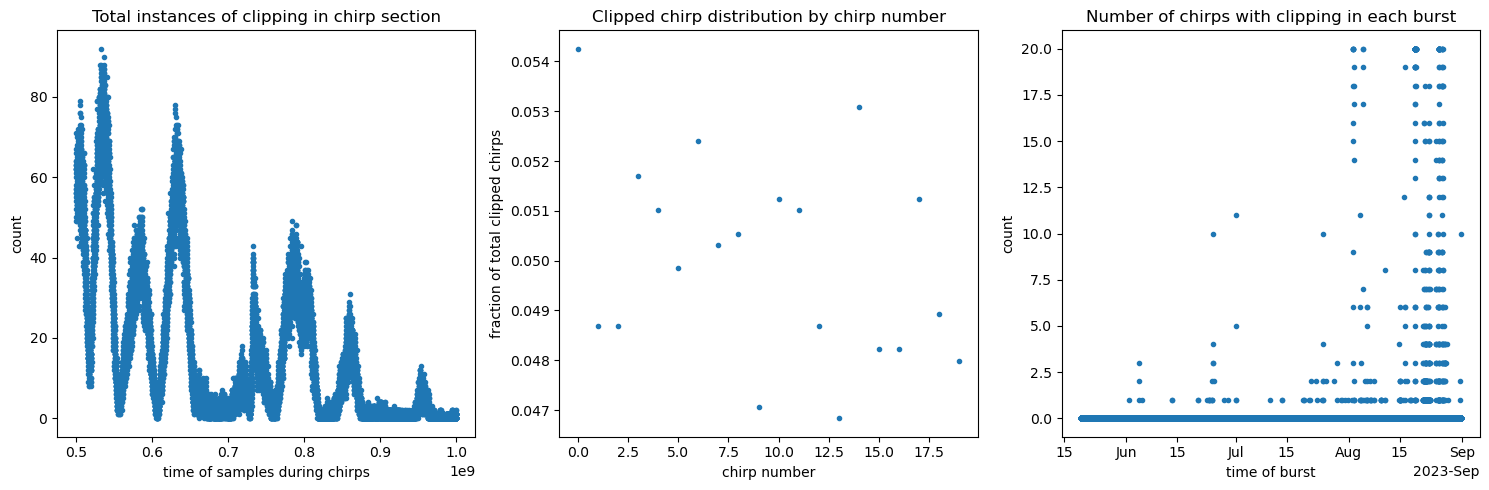

In [51]:
# half waveform
bad_chirp_condition = abs(ds_103_s.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_103_s.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

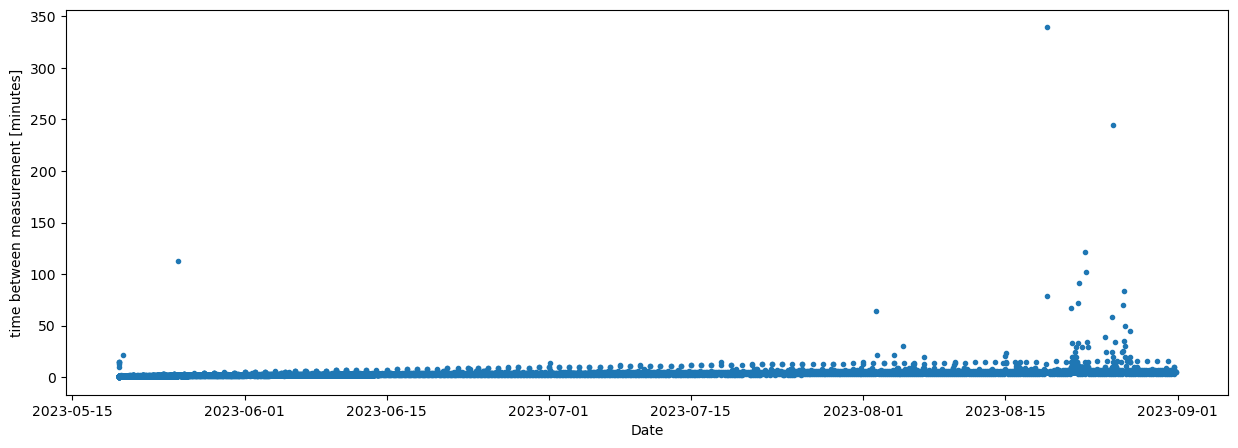

In [39]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_103_s.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_103_s.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

# A14

## Summer 2022

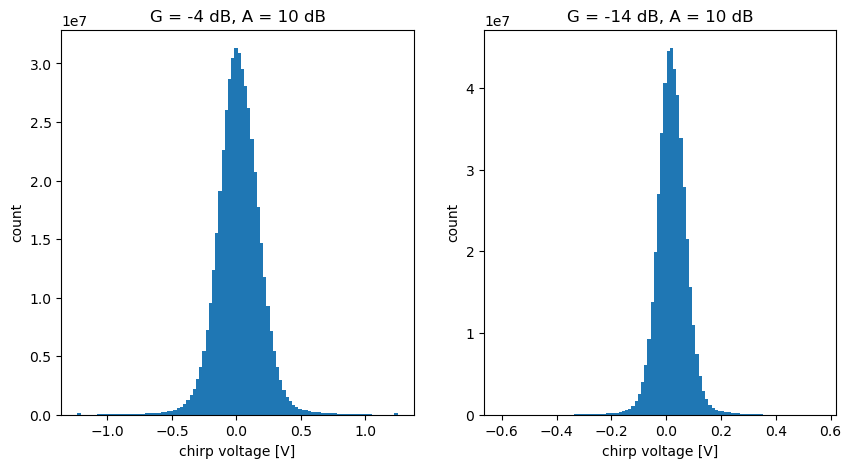

In [63]:
plot_hist(ds_104)

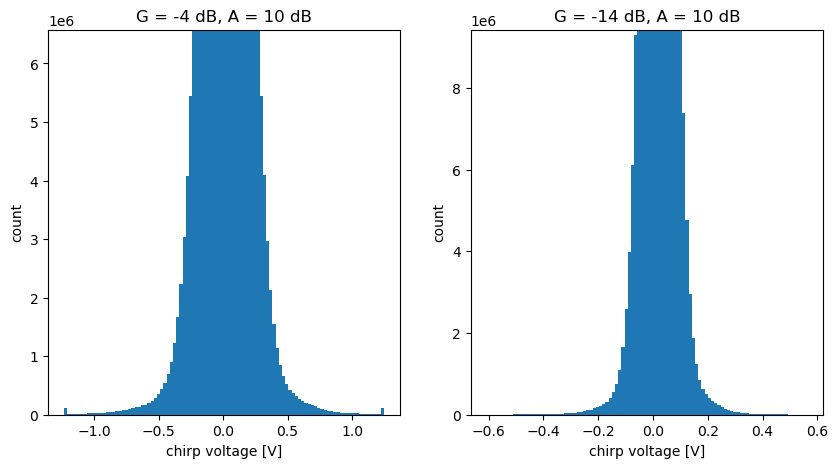

In [43]:
plot_hist(ds_104,ylim=True)

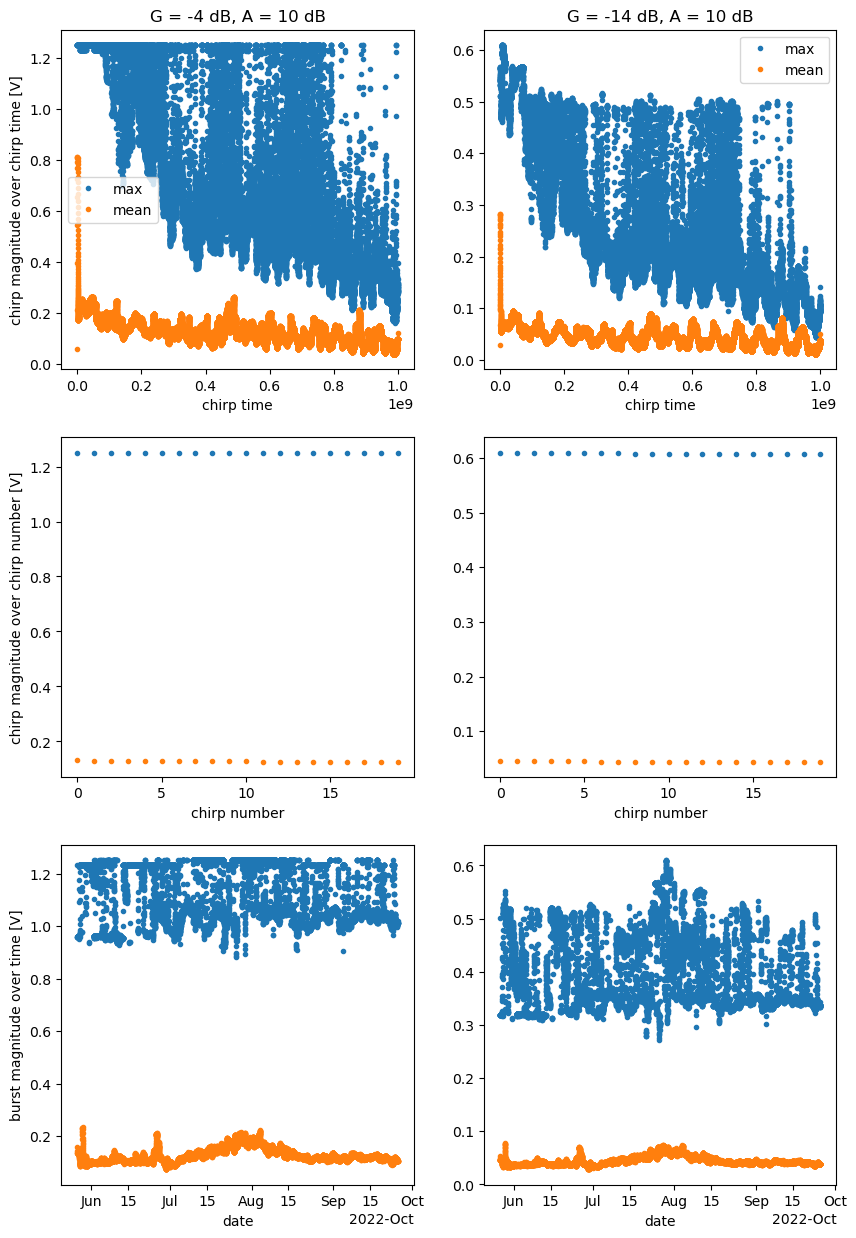

In [42]:
plot_amplitude_trends(ds_104)

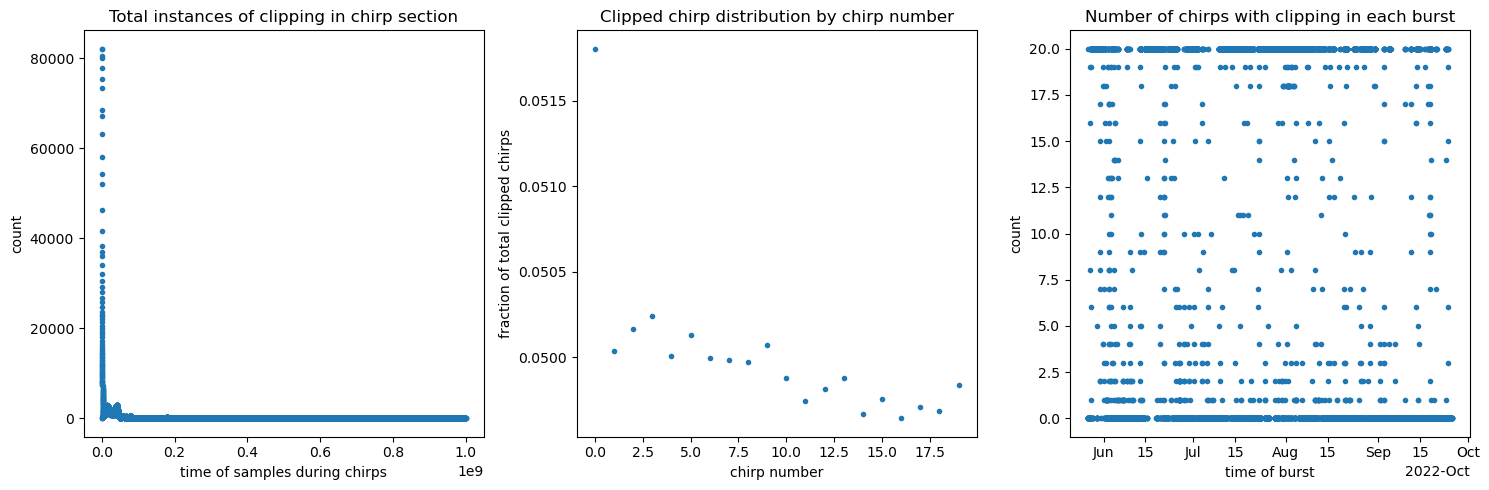

In [27]:
bad_chirp_condition = abs(ds_104.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

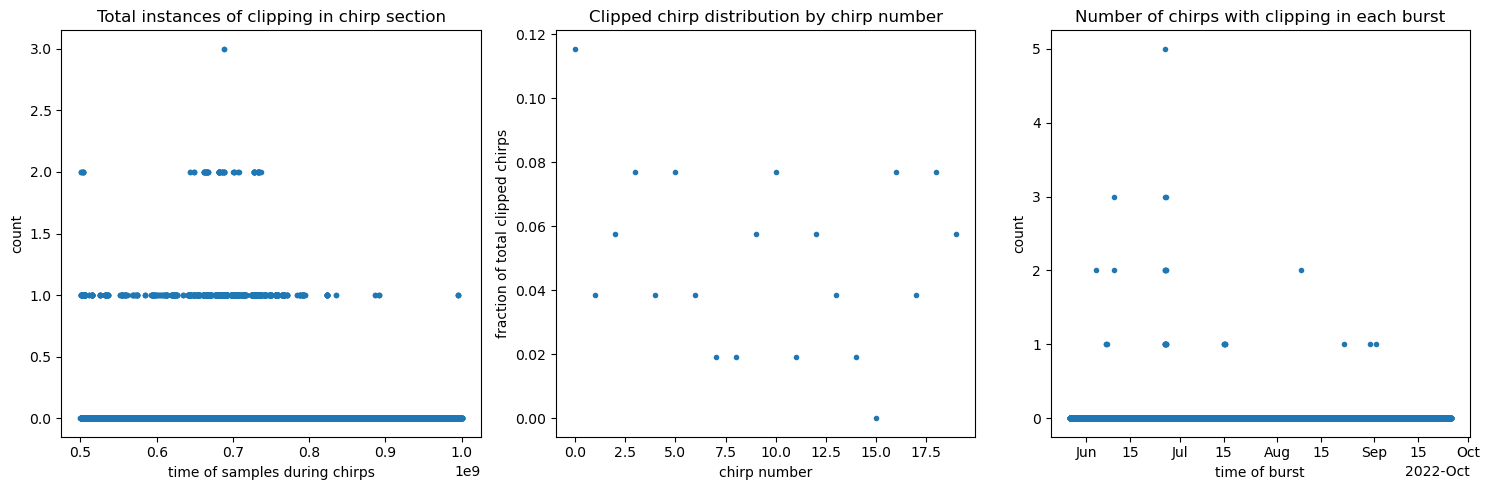

In [52]:
# half waveform
bad_chirp_condition = abs(ds_104.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

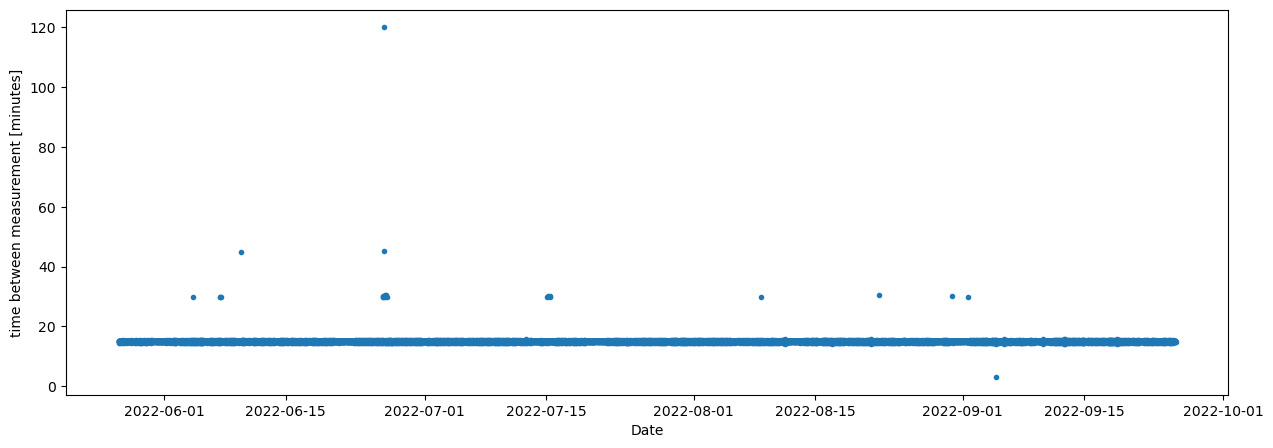

In [40]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_104.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_104.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')

## Winter 2022-2023

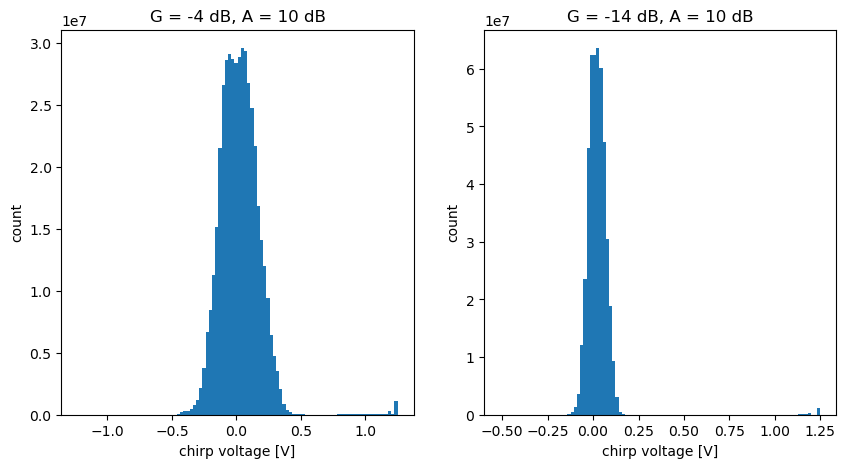

In [10]:
plot_hist(ds_104_w)

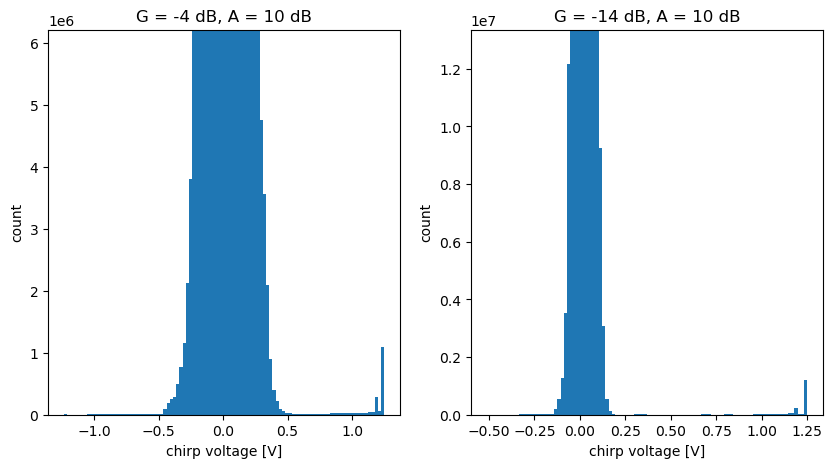

In [44]:
plot_hist(ds_104_w,ylim=True)

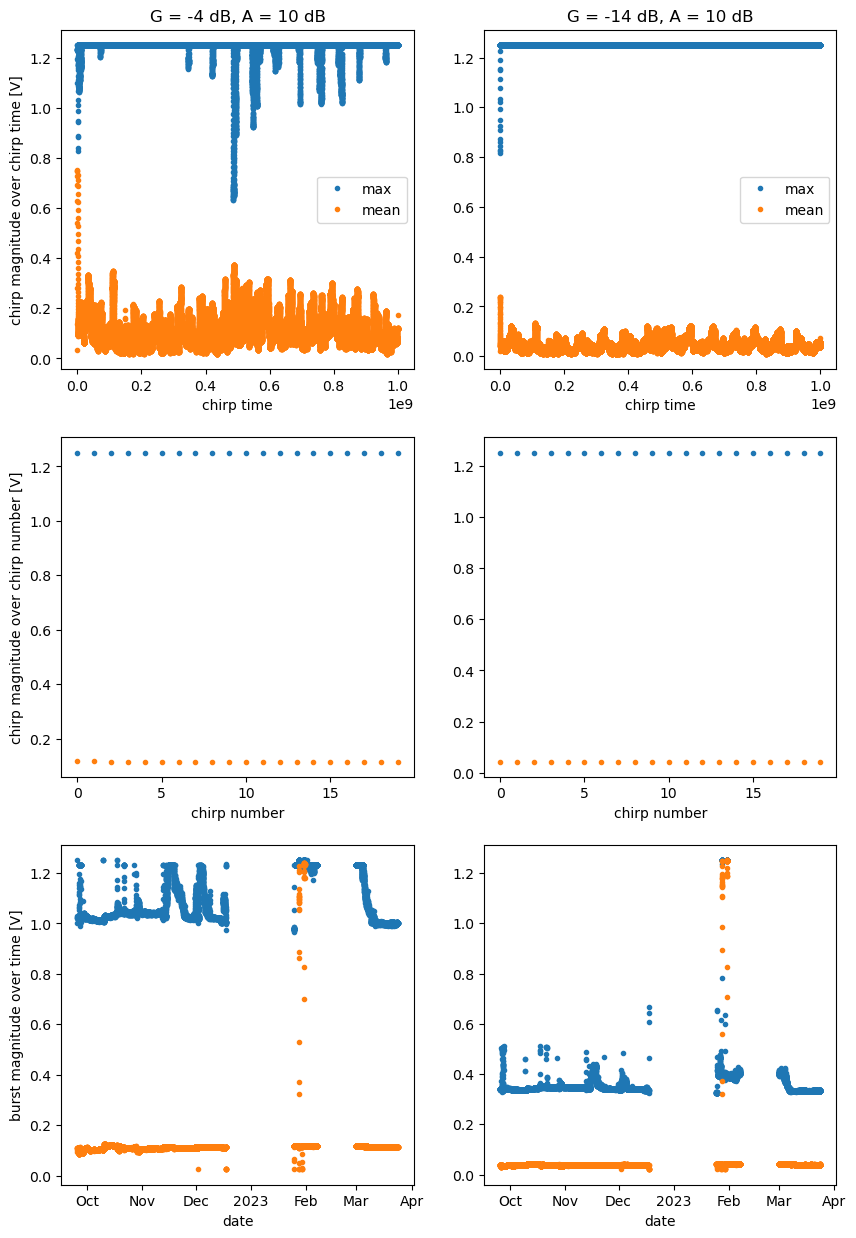

In [17]:
plot_amplitude_trends(ds_104_w)

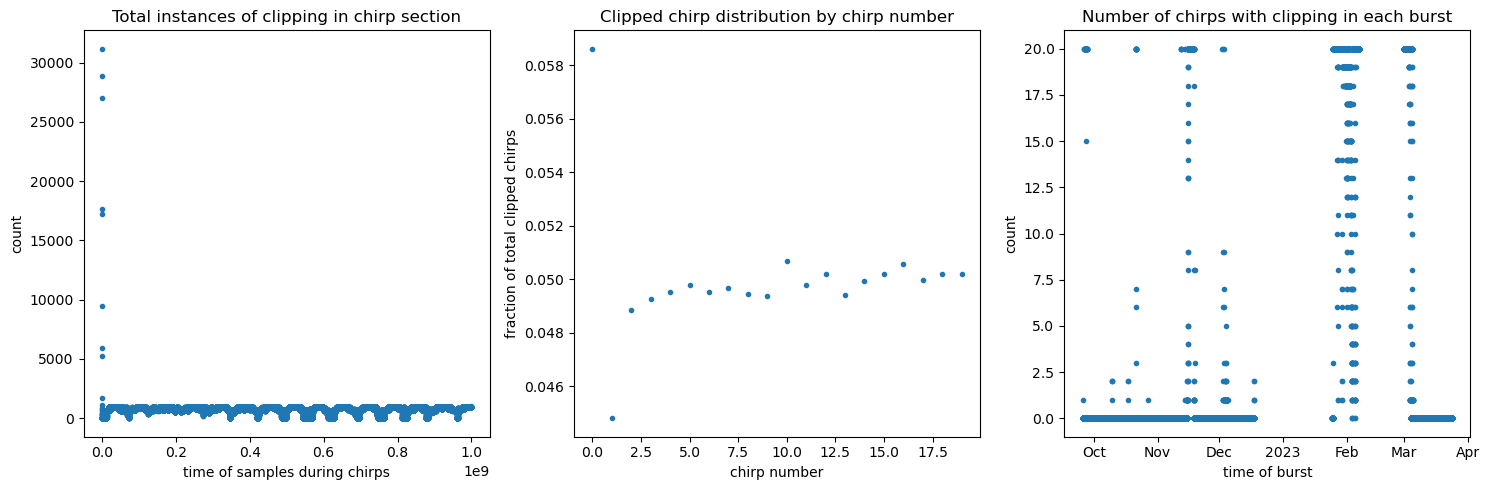

In [28]:
bad_chirp_condition = abs(ds_104_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104_w.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

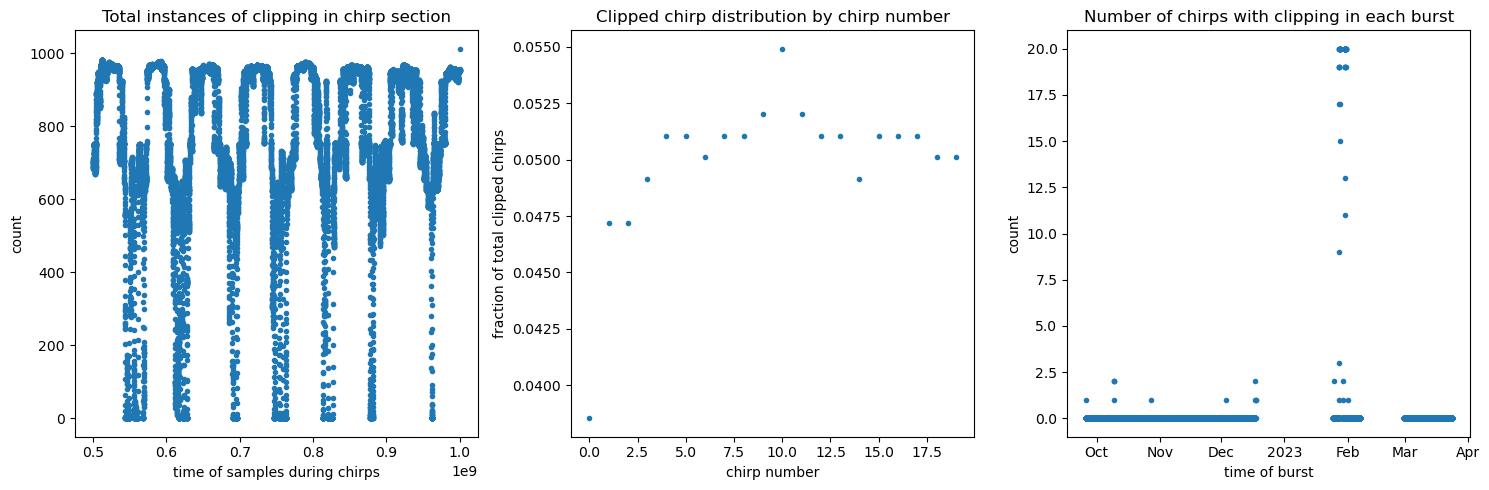

In [53]:
# half waveform
bad_chirp_condition = abs(ds_104_w.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104_w.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

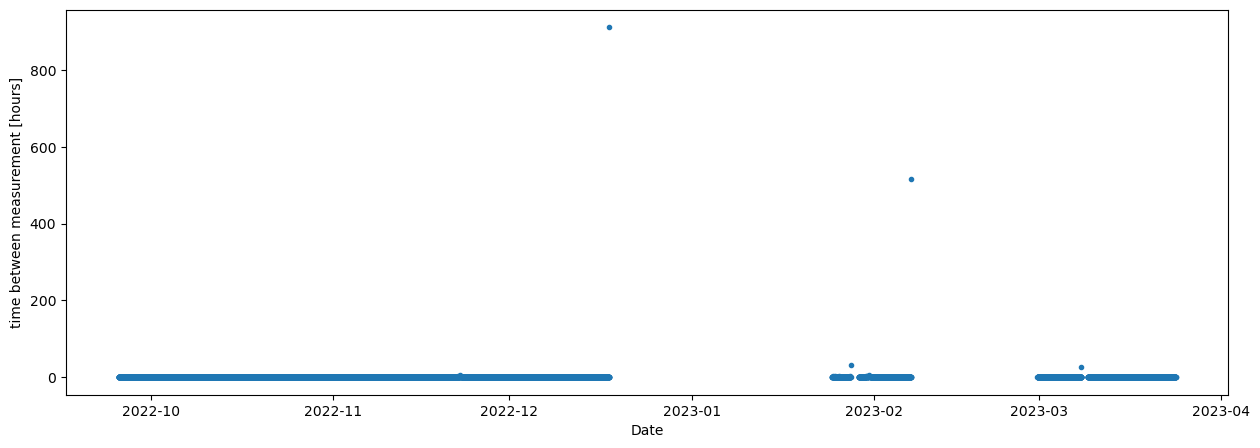

In [43]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_104_w.isel(attenuator_setting_pair=0,chirp_time=range(100,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_104_w.isel(attenuator_setting_pair=0,chirp_time=range(100,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/3600,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [hours]')
ax.set_xlabel('Date')

(0.0, 10.0)

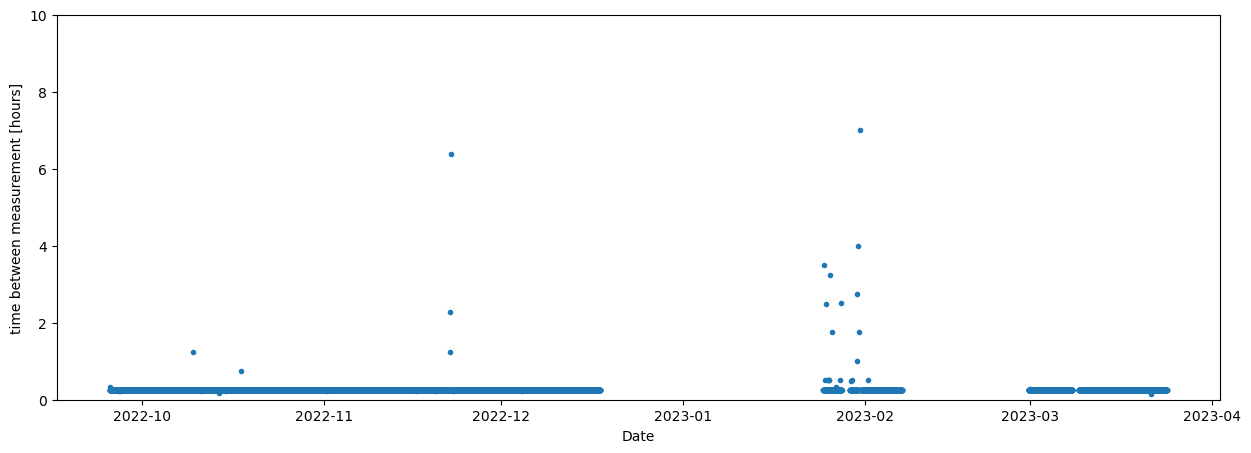

In [44]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/3600,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [hours]')
ax.set_xlabel('Date')
ax.set_ylim([0,10])

## Summer 2023

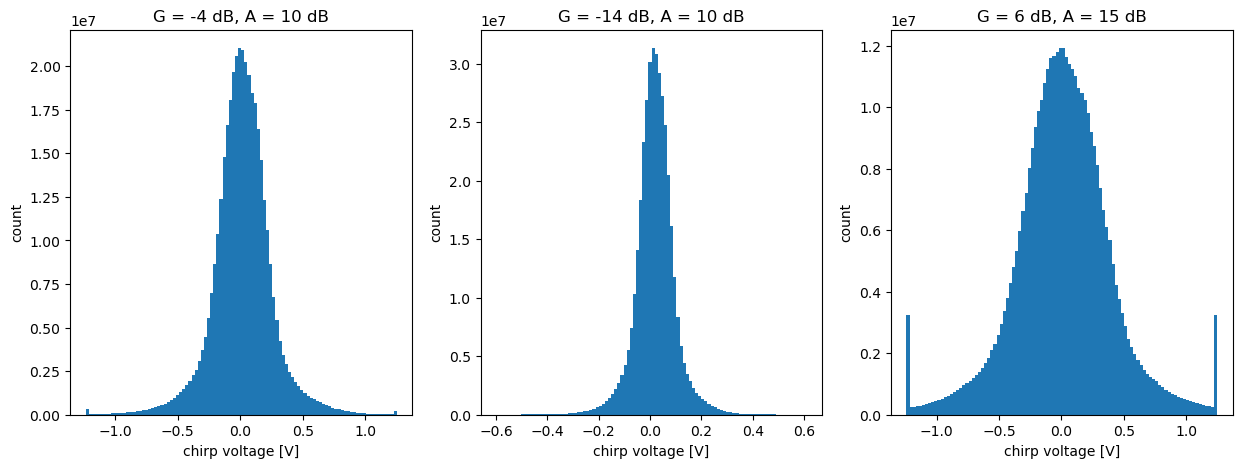

In [18]:
plot_hist(ds_104_s)

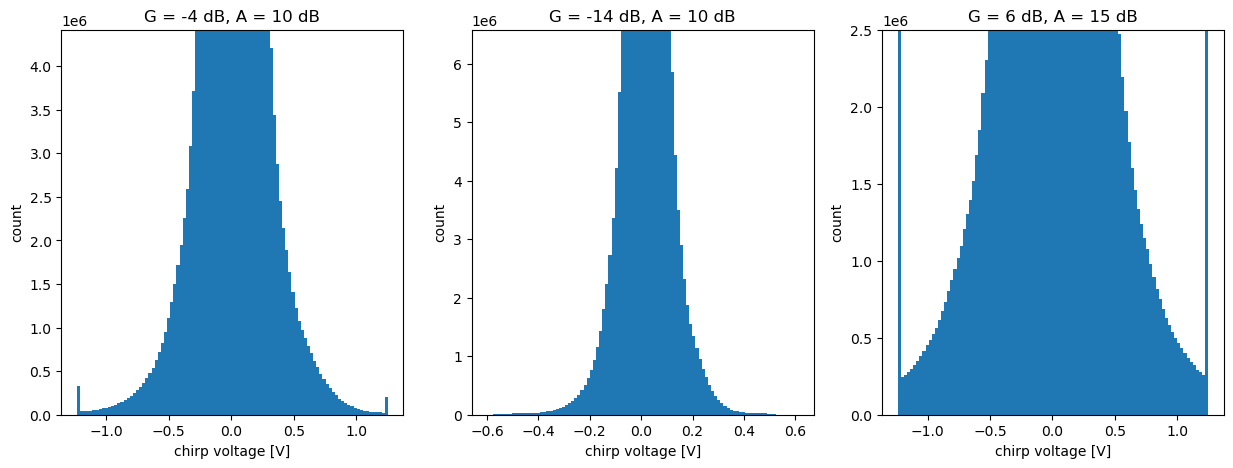

In [45]:
plot_hist(ds_104_s,ylim=True)

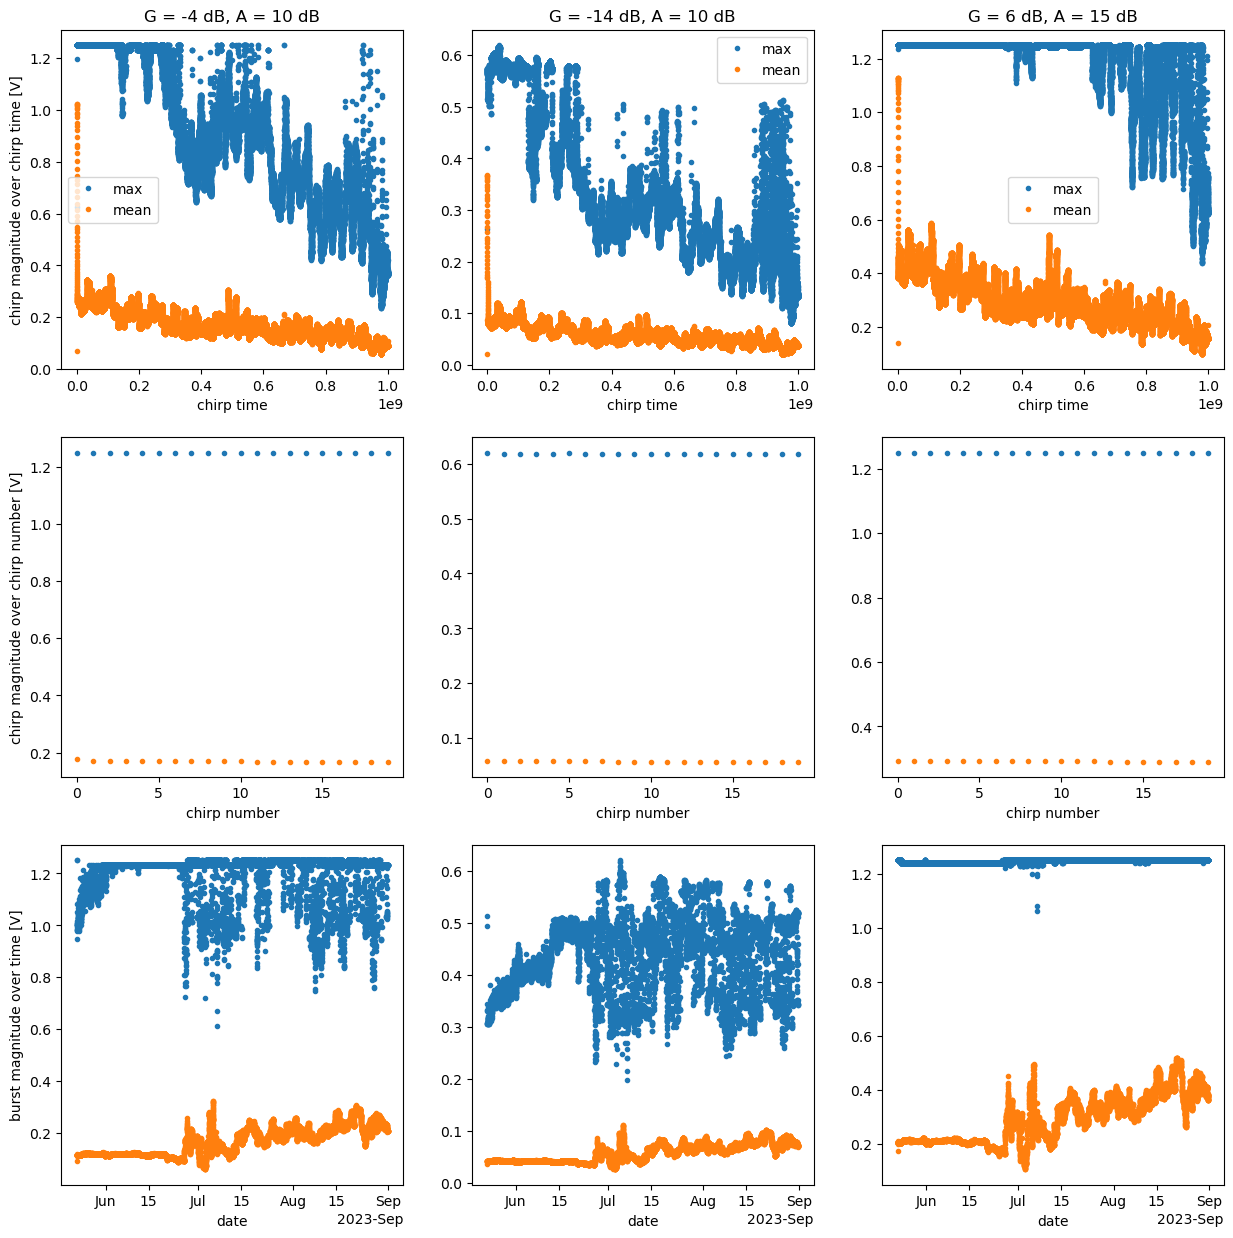

In [19]:
plot_amplitude_trends(ds_104_s)

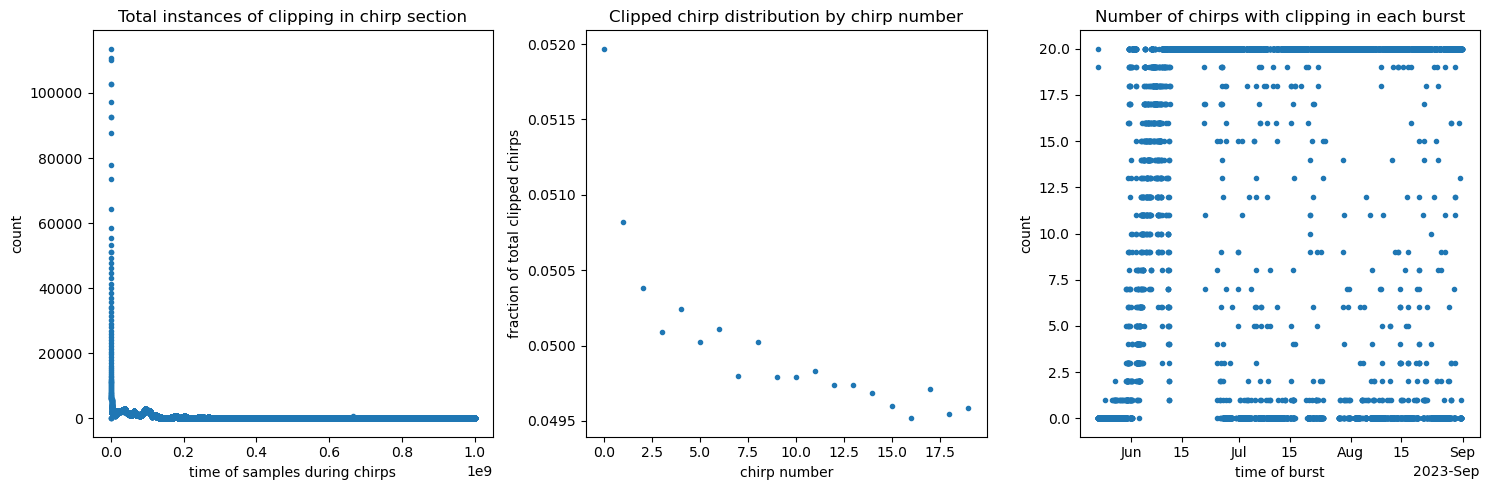

In [29]:
bad_chirp_condition = abs(ds_104_s.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104_s.isel(attenuator_setting_pair=0).chirp.where(bad_chirp_condition))

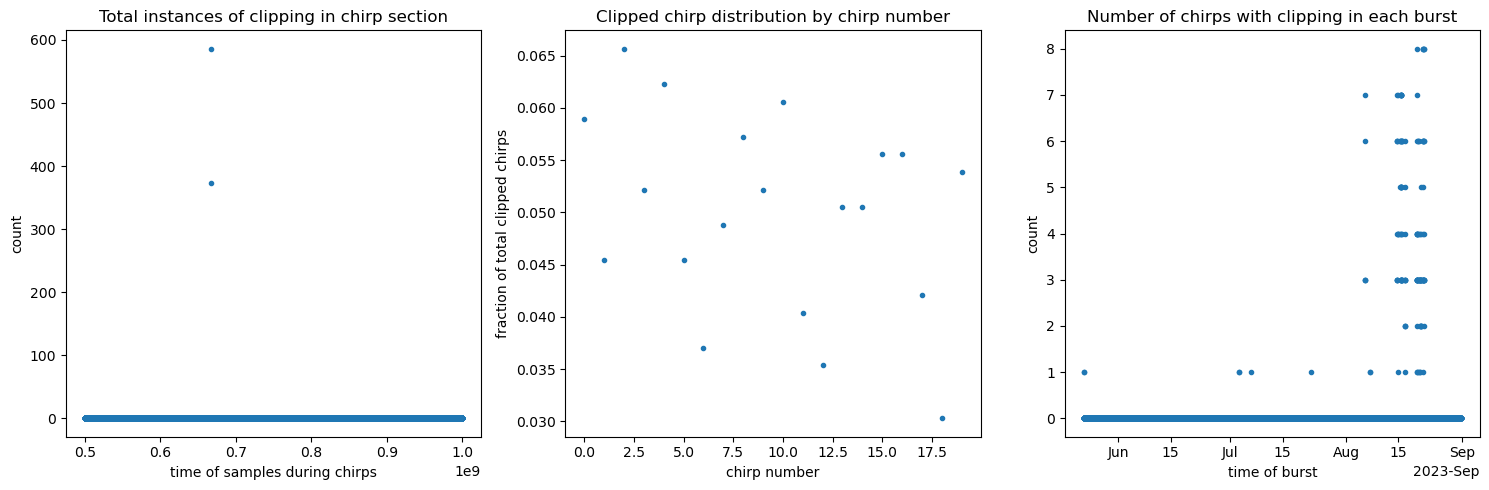

In [54]:
# half waveform
bad_chirp_condition = abs(ds_104_s.isel(attenuator_setting_pair=0).chirp) > 1.2

plot_bad_chirp_count(ds_104_s.isel(attenuator_setting_pair=0,chirp_time=range(20000,40001)).chirp.where(bad_chirp_condition))

Text(0.5, 0, 'Date')

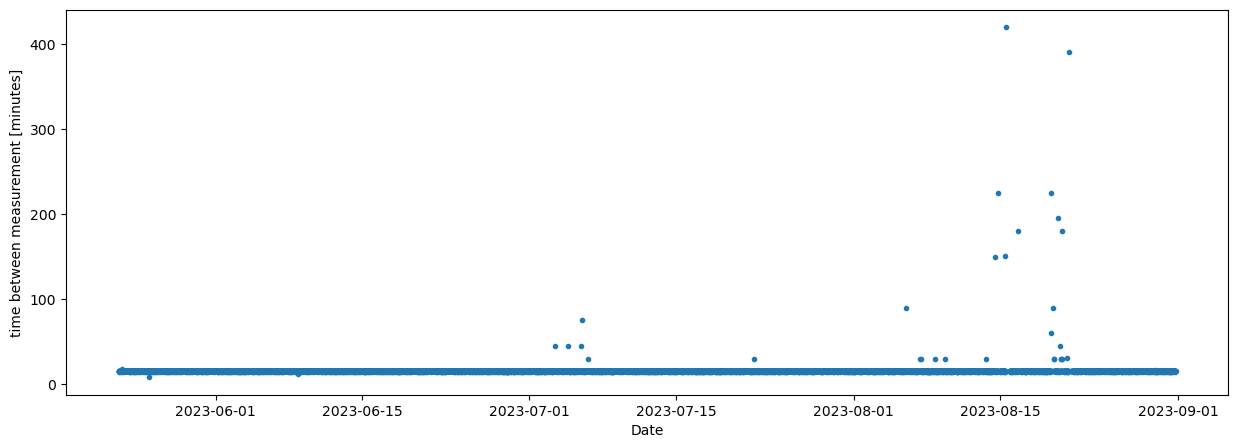

In [42]:
# check time gap distribution if only using half chirp and discarding remaining clipped chirps 
condition = ds_104_s.isel(attenuator_setting_pair=0,chirp_time=range(10000,40001)).chirp.max(dim=['chirp_num','chirp_time']).compute() <= 1.2
good_bursts = ds_104_s.isel(attenuator_setting_pair=0,chirp_time=range(10000,40001),time=condition)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(good_bursts.chirp.time.values[0:-1],np.diff(good_bursts.chirp.time.values.astype("float64"))/1e9/60,marker='.',linestyle='None')
ax.set_ylabel('time between measurement [minutes]')
ax.set_xlabel('Date')